# Final Exam Project:  COVID-19 Reasearch Paper Analysis

## <center>Table of Contents</center>


- **Import Libraries**


- **1. Data Cleaning**
    - 1.1 Drop Duplicates and NaNs
    
    - 1.2 Read Json Files and Add Body Text from Local
        - biorxiv_medrxiv
        - comm_use_subset
        - noncomm_use_subset
        - custom_license
        
    - 1.3 Add Word Count for Abstract and Body_text
    
    - 1.4 Remove Punctuations
    
    - 1.5 Lowercase
    
    - 1.6 Remove Stopwords and Lemmatize
    
    
- **2. Data Visualizations and Exploratory Data Analysis**
    - 2.1 Most Common Words in Titles and Abstracts
    
    - 2.2 Most Common Noun Phrases in Titles and Abstracts
    
    - 2.3 Frequency of Coronavirus Mentions (COVID-19, SARS and MERS)
    
    - 2.4 Topics Mentioned
        - 2.4.1 Latent Dirichlet Allocation on Titles
        - 2.4.2 Insights from Kaggle
    
    - 2.5 Preliminary Insights on Risk Factors in Abstracts only
    
    
- **3. Models Implementation**
    - 3.1 Retrieval System for Papers Relevent to Risk Factors 
        - 3.1.1 Get TFIDF Features for Entire Texts for Each Paper
        - 3.1.2 Retrieval System
        - 3.1.3 Keywords in the Relevant Papers
        
    - 3.2 Hierarchical Clustering on Risk Factors
        - 3.2.1 Insights in Risk Factors from Entire Texts 
        - 3.2.2 Calculate Distance Between Risk Factors
        - 3.2.3 Clustering Risk Factors by Hierarchical Clustering and Dendrogram
        
    - 3.3 K-Mean Clustering on Top 20 papers related to Each Risk Factor
        - 3.3.1 Extract Relevant Papers related to Each Risk Factor
        - 3.3.2 Build K-mean Model
        - 3.3.3 Visualize the Clusters in K-mean by T-SNE
        - 3.3.4 Visualize Key Terms in Clusters
        
    - 3.4 Document Searching in Risk Factors Clusters
    
    
- **4. Discussion**

## Introduction

This project is mainly focus on getting insights on risk factors from research papers related to coronavirus to help our health system, government, industries and individuals to tackle this growing problem. NLP, recommender sytem, information retrieval system, hierarchical and K-mean clustering models are used to develop a sequence of process to extract prevalent risk factors and their related potential ones mentioned in the papers to help people even more.

In [1]:
#load data and preprocess
import numpy as np 
import pandas as pd 
import os
import json
import re

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import KElbowVisualizer


#clean data
import nltk
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("averaged_perceptron_tagger")
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#model implementation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

/Users/barry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
[nltk_data] Downloading package stopwords to /Users/barry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/barry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/barry/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# <center>1. Data Cleaning</center>

### 1.1 Drop Duplicates and NaNs

Some research papers are published by many publishers and they all have same abstracts and titles, therefore, I only keep the first paper and drop the other duplicates. Then, papers with missing values are dropped.

In [49]:
# load the meta data from the CSV file 
df = pd.read_csv('metadata.csv', usecols=['sha','title','abstract','authors','doi','publish_time','url'])

#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df = df.dropna()

#reindex the dataframe after dropping duplicates and missing values
df.index = list(range(len(df)))

### 1.2 Read Json Files and Add Body Text from Local

There are three files contain the body texts of some of the research papers in json format, I downloaded the files to **my local directory** and I used the directories to open the four files separately. The four files are: biorxiv_medrxiv, comm_use_subset, noncomm_use_subset and custom_license, they are all from the folder called 'CORD-19-research-challenge'. Json format has same structure as the dictionary in python, and each research paper will has its own diretory, the directory is opened and its paper_id and body_text are retrieved. Then, for the original dateframe form 'metadata.csv', the paper_id retrived must match with the 'sha' column in the original dataframe (unique id for each research paper), then a new column called 'body_text' is created and body texts are added for each paper.

In [50]:
# def get_body_text_bm(json_name):
    
#     #create directory for reading
#     directory = '/Users/Barry/Desktop/1624 Final/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/' + json_name
#     file = open(directory,'r')
    
#     #read json files
#     read_file = json.load(file)
    
#     #get id to match
#     paper_id = read_file['paper_id']
    
#     #get body_text string
#     content = []
#     for text in read_file['body_text']:
#         content.append(text['text'])
#     body_text = (' ').join(content)
       
#     return paper_id, body_text

In [51]:
# #create a new column
# df['body_text'] = ''
# files = os.listdir('/Users/Barry/Desktop/1624 Final/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv')
# for file in files:
#     paper_id, body_text = get_body_text_bm(file)
#     df.loc[df['sha']==paper_id,'body_text'] = body_text

In [52]:
# def get_body_text_cs(json_name):
    
#     #create directory for reading
#     directory = '/Users/Barry/Desktop/1624 Final/CORD-19-research-challenge/comm_use_subset/comm_use_subset/' + json_name
#     file = open(directory,'r')
    
#     #read json files
#     read_file = json.load(file)
    
#     #get id to match
#     paper_id = read_file['paper_id']
    
#     #get body_text string
#     content = []
#     for text in read_file['body_text']:
#         content.append(text['text'])
#     body_text = (' ').join(content)
       
#     return paper_id, body_text

In [53]:
# #create a new column
# files = os.listdir('/Users/Barry/Desktop/1624 Final/CORD-19-research-challenge/comm_use_subset/comm_use_subset')
# for file in files:
#     paper_id, body_text = get_body_text_cs(file)
#     df.loc[df['sha']==paper_id,'body_text'] = body_text

In [54]:
# def get_body_text_ncs(json_name):
    
#     #create directory for reading
#     directory = '/Users/Barry/Desktop/1624 Final/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/' + json_name
#     file = open(directory,'r')
    
#     #read json files
#     read_file = json.load(file)
    
#     #get id to match
#     paper_id = read_file['paper_id']
    
#     #get body_text string
#     content = []
#     for text in read_file['body_text']:
#         content.append(text['text'])
#     body_text = (' ').join(content)
       
#     return paper_id, body_text

In [55]:
# #create a new column
# files = os.listdir('/Users/Barry/Desktop/1624 Final/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset')
# for file in files:
#     paper_id, body_text = get_body_text_ncs(file)
#     df.loc[df['sha']==paper_id,'body_text'] = body_text

In [56]:
# def get_body_text_cl(json_name):
    
#     #create directory for reading
#     directory = '/Users/Barry/Desktop/1624 Final/CORD-19-research-challenge/custom_license/custom_license/' + json_name
#     file = open(directory,'r')
    
#     #read json files
#     read_file = json.load(file)
    
#     #get id to match
#     paper_id = read_file['paper_id']
    
#     #get body_text string
#     content = []
#     for text in read_file['body_text']:
#         content.append(text['text'])
#     body_text = (' ').join(content)
       
#     return paper_id, body_text

In [57]:
# #create a new column
# files = os.listdir('/Users/Barry/Desktop/1624 Final/CORD-19-research-challenge/custom_license/custom_license')
# for file in files:
#     paper_id, body_text = get_body_text_cl(file)
#     df.loc[df['sha']==paper_id,'body_text'] = body_text

In [58]:
# df.head(3)

,sha,title,doi,abstract,publish_time,authors,url,body_text
0,f056da9c64fbf00a4645ae326e8a4339d015d155,SIANN: Strain Identification by Alignment to N...,10.1101/001727,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,https://doi.org/10.1101/001727,There are many different methods that characte...
1,daf32e013d325a6feb80e83d15aabc64a48fae33,Spatial epidemiology of networked metapopulati...,10.1101/003889,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,https://doi.org/10.1101/003889,The term metapopulation was coined by Levins [...
2,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,Sequencing of the human IG light chain loci fr...,10.1101/006866,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,https://doi.org/10.1101/006866,Antibodies are essential components of the imm...


### 1.3 Add Word Count for Abstract and Body_text

In [60]:
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))
df['body_word_count'] = df['body_text'].apply(lambda x: len(x.strip().split()))

### 1.4 Remove Punctuations

In [61]:
df['abstract'] = df['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df['body_text'] = df['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

### 1.5 Lowercase

In [62]:
df['abstract'] = df['abstract'].str.lower()
df['body_text'] = df['body_text'].str.lower()

### 1.6 Remove Stopwords and Lemmatize

In this section, both the body texts and abstracts are cleaned.

- Remove Stopwords
- Tokenize sentences into words
- lemmatize the words into common form (romove their roots to reduce number of features)

Since the time for cleaning is **extremely slow**, the preprocessed dataframe is then exported as **'df_processed.csv'** for future works.

In [16]:
for i in range(len(df)):
    
    text = df['abstract'][i]
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()

    text = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text) if word not in stopwords.words('english')]

    df['abstract'][i] = text

/Users/barry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [17]:
for i in range(len(df)):
    
    text = df['body_text'][i]
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()

    text = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text) if word not in stopwords.words('english')]

    df['body_text'][i] = text

/Users/barry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [59]:
#df.to_csv('df_processed.csv')

# <center>2. Data Visulization and EDA</center>

In [3]:
#load processed dataset
df = pd.read_csv('df_processed.csv')
df.head(3)

,Unnamed: 0,Unnamed: 0.1,sha,title,doi,abstract,publish_time,authors,url,body_text,abstract_word_count,body_word_count
0,0,0,f056da9c64fbf00a4645ae326e8a4339d015d155,SIANN: Strain Identification by Alignment to N...,10.1101/001727,"['nextgeneration', 'sequencing', 'increasingly...",2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,https://doi.org/10.1101/001727,"['many', 'different', 'method', 'characterize'...",184,3692
1,1,1,daf32e013d325a6feb80e83d15aabc64a48fae33,Spatial epidemiology of networked metapopulati...,10.1101/003889,"['emerging', 'disease', 'one', 'infectious', '...",2014-06-04,Lin WANG; Xiang Li,https://doi.org/10.1101/003889,"['term', 'metapopulation', 'coined', 'levins',...",136,5000
2,2,2,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,Sequencing of the human IG light chain loci fr...,10.1101/006866,"['germline', 'variation', 'immunoglobulin', 'g...",2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,https://doi.org/10.1101/006866,"['antibody', 'essential', 'component', 'immune...",200,5478


### 2.1 Most Common Words in Titles and Abstract

From the two bar plots below, we can see the top 20 keywords appeared in both titles and abstracts are very similar and they all are related to descriptions of virus such as 'virus' and 'infection' which are the most two common words in both sections of the papers, other words like 'cell', 'protein' and 'influenza' tend to focus on the inner structures of the viruses, and it is worth to mention that words like 'analysis', 'response', 'study' and 'method' are likely to be the measures and investigations that people are taken on these papers. In conclusion, according to the top keywords appeared in the titles and abstracts in papers, we can roughly say that these papers are focusing mainly on three areas: descriptions of viruses, inner structures of virus and people's analysis and studies on these viruses. However, more detailed information can not only be focusing on the single words since single words may not give the full descriptions for a entire paper, therefore, NOUN-PHRASES are extracted from the original papers (without preprocessing) to see if there will be more information.

In [4]:
#define function can find top k keywords in specified column
def topk(df,k,col):
    
    lemmatizer = WordNetLemmatizer()
    stops = set(stopwords.words('english'))
    lines = df[col].values
    counter = Counter()
    for line in lines:
        counter.update([lemmatizer.lemmatize(word.lower()) for word in re.findall(r'\w+', line) if word.lower() not in stops and len(word) > 2])
    topk = counter.most_common(k)
    
    return topk

In [5]:
#get top 20 keywords in the title and abstract columns, respectively
titles = topk(df,k=20,col='title')
abstracts = topk(df,k=20,col='abstract')

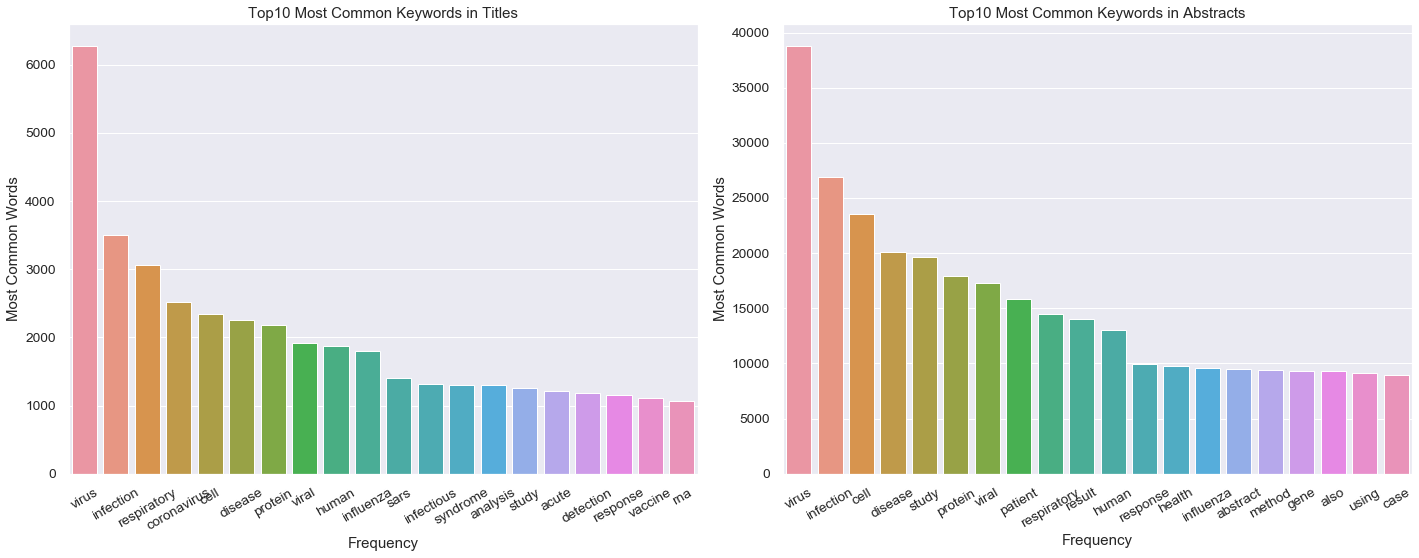

In [6]:
#create subplots to show the keywords and their corresponding frequency
plt.figure(figsize=(20,8))
sns.set(font_scale=1.25)

x,y = map(list,zip(*titles))
plt.subplot(1,2,1)
sns.barplot(x=x,y=y)
plt.title('Top10 Most Common Keywords in Titles')
plt.xlabel('Frequency')
plt.xticks(rotation=30)
plt.ylabel('Most Common Words')

x, y = map(list, zip(*abstracts))
plt.subplot(1,2,2)
sns.barplot(x=x,y=y)
plt.title('Top10 Most Common Keywords in Abstracts')
plt.xlabel('Frequency')
plt.xticks(rotation=30)
plt.ylabel('Most Common Words')
plt.tight_layout()
plt.show()

### 2.2 Most Common Noun Phrases in Titles and Abstract

As we can see from the two bar plots of noun phrases below, we can clearly get relatively more infomation than those single keywords. Firstly, we can see most of the papers are talking about SARS and MERS which are two very deadly virus appeared in recent years and other terminologies related to viruses are also frequently mentioned; secondly, some terminologies such as 'antiviral activities', 'risk factors', immune response', 'present study' and so on are closely related to the measures and investigations that people are working on.


However, this may lead to a potential problem: since most of the papers are talking about SARS and MERS and other types of viruses, COVID-19 is barely mentioned in these research papers. Therefore, we need to explore more and extract useful information from these papers to help people study more on COVID-19. In this project, I mainly focuses on the risk factors of viruses since there may be significant amount of papers related to risk factors for viruses as 'Risk Factor' appears very frequently in both titles and abstracts from the bar plots.

In [7]:
#load original dataset without any cleaning
df_meta = pd.read_csv('metadata.csv', usecols=['sha','title','abstract','authors','doi','publish_time','url'])
df_meta = df_meta.drop_duplicates(subset='abstract', keep="first")
df_meta = df_meta.dropna()
df_meta.index = list(range(len(df_meta)))
df_meta.head(3)

,sha,title,doi,abstract,publish_time,authors,url
0,f056da9c64fbf00a4645ae326e8a4339d015d155,SIANN: Strain Identification by Alignment to N...,10.1101/001727,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,https://doi.org/10.1101/001727
1,daf32e013d325a6feb80e83d15aabc64a48fae33,Spatial epidemiology of networked metapopulati...,10.1101/003889,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,https://doi.org/10.1101/003889
2,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,Sequencing of the human IG light chain loci fr...,10.1101/006866,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,https://doi.org/10.1101/006866


In [8]:
#define taggers
tagger = PerceptronTagger()
pos_tag = tagger.tag

grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [9]:
# Noun Phrase Extraction Support Functions
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords_eng)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [10]:
#define funtion to extract top k noun phrases
def topk_NP(df,k,col):
    
    lines = df[col].values
    counter = Counter()
    for line in lines:
            counter.update(flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', line))))]))
    topk = counter.most_common(k)
    
    return topk

In [11]:
# get top 20 noun phrases form titles and abstracts
titles_NP = topk_NP(df_meta,k=20,col='title')
abstracts_NP = topk_NP(df_meta,k=20,col='abstract')

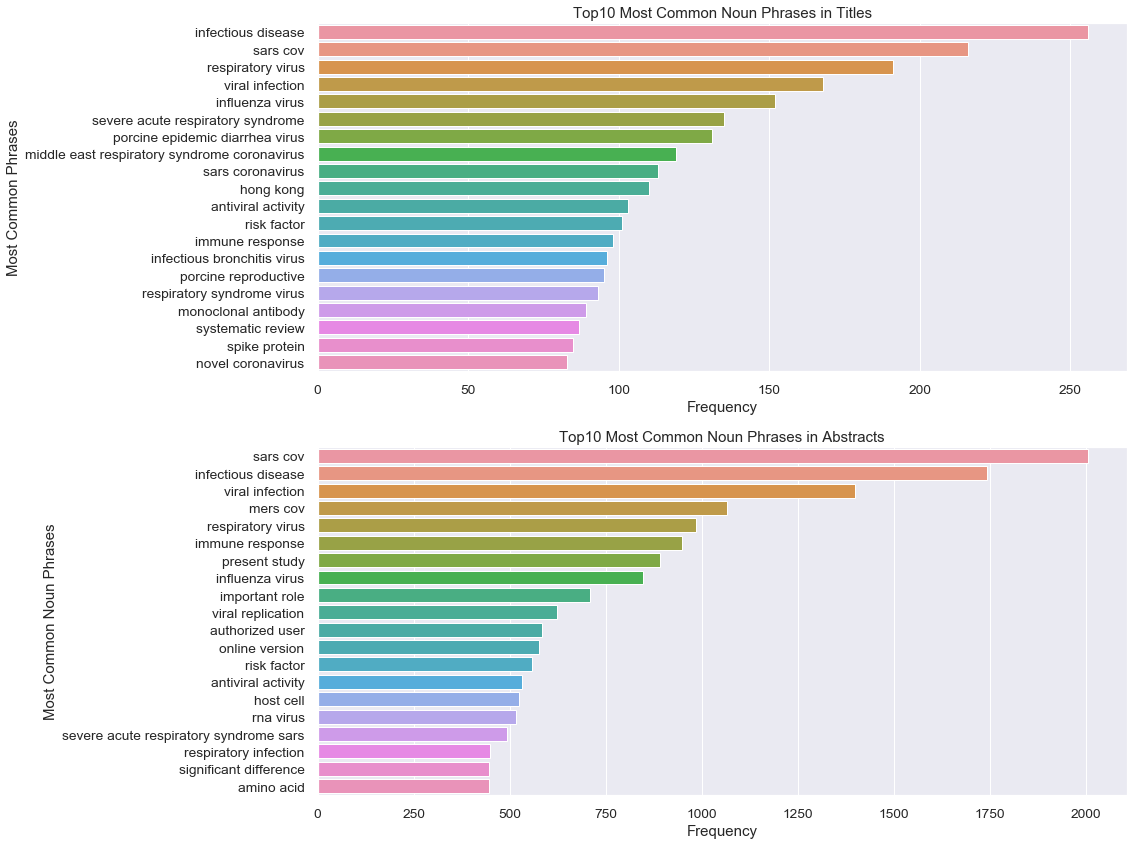

In [12]:
#create subplots to show the noun phrases and their corresponding frequency
plt.figure(figsize=(16,12))

x,y = map(list,zip(*titles_NP))
plt.subplot(2,1,1)
sns.barplot(x=y,y=x)
plt.title('Top10 Most Common Noun Phrases in Titles')
plt.xlabel('Frequency')
plt.ylabel('Most Common Phrases')

x, y = map(list, zip(*abstracts_NP))
plt.subplot(2,1,2)
sns.barplot(x=y,y=x)
plt.title('Top10 Most Common Noun Phrases in Abstracts')
plt.xlabel('Frequency')
plt.ylabel('Most Common Noun Phrases')
plt.tight_layout()
plt.show()

### 2.3 Frequency of Coronavirus Mentions (COVID-19, SARS and MERS)

As we discussed before, most of the papers are discussing SARS and MERS, bery few papers are related to COVID-19 since it just emerges to the world for couple of months. The frequency of mentions of SARS and MERS are almost 10 times and 6 times bigger than the COVID-19, respectively.

In [13]:
corona = {
    'COVID-19':['covid19','sarscov2','sars2','coronavirus2', '2019ncov'],
    'MERS': ['mers','mer','merscov'],
    'SARS':['sars', 'sar', 'sarscov'],
}

In [14]:
virus_mentioned = dict((c,0) for c in corona)
for virus in virus_mentioned:
    keywords = corona[virus]
    for word in keywords:
        for text in df['abstract']:
            if str(word) in text:
                virus_mentioned[virus] += 1

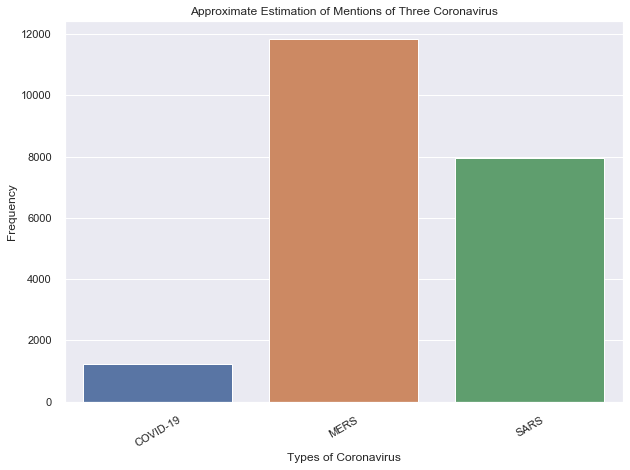

In [15]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1)
sns.barplot(x=list(virus_mentioned.keys()),y=list(virus_mentioned.values()))
plt.title('Approximate Estimation of Mentions of Three Coronavirus')
plt.xlabel('Types of Coronavirus')
plt.xticks(rotation=30)
plt.ylabel('Frequency')
plt.show()

### 2.4 Topics Mentioned

To further support my analysis on risk factors, I also found some motivations from the papers. I want to compare the topics that either generated from models or people defined, and see whether risk factor needs to be investigated more by data analysis.

##### 2.4.1 Latent Dirichlet Allocation on Titles

Firstly, I try to see the topics generated from models. I am trying to find 10 topic categories over all the papers by using LDA analysis on the paper titles only, the results shown are not very promising. Some topics provide relatively meaningful information, for topic 2 as an example, the three main categories of coronavirus are categorized together and topic 7 seems like to have words related to people's studies and analysis on the viruses. Overall, the topics categorized by LDA model are not very interpretable to me, therefore, I try to use pre-defined questions provided by Kaggle and see the distributions of some hot topics.

In [16]:
count_vec = CountVectorizer(stop_words='english')
title_matrix = count_vec.fit_transform(df_meta['title'].values.astype('U'))
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
LDA.fit(title_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [17]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 20 words for topic #{i+1}:')
    print([count_vec.get_feature_names()[i] for i in topic.argsort()[-1:-21:-1]])

Top 20 words for topic #1:
['respiratory', 'infections', 'acute', 'influenza', 'infection', 'viral', 'virus', 'children', 'patients', 'human', 'clinical', 'pneumonia', 'viruses', 'detection', 'h1n1', 'tract', 'severe', 'associated', 'disease', 'study']
Top 20 words for topic #2:
['coronavirus', 'sars', 'protein', 'cov', 'syndrome', 'respiratory', 'novel', 'mers', 'human', 'proteins', 'viral', 'binding', 'middle', '2019', 'east', 'spike', 'domain', 'rna', 'structural', 'structure']
Top 20 words for topic #3:
['viruses', 'rna', 'diseases', 'viral', 'infectious', 'emerging', 'host', 'disease', 'human', 'new', 'virus', 'transmission', 'bats', 'analysis', 'immunity', 'role', 'coronaviruses', 'innate', 'chapter', 'recent']
Top 20 words for topic #4:
['calves', 'chapter', 'viral', 'vaccine', 'central', 'potential', 'dairy', 'based', 'vaccines', 'high', 'nervous', 'infection', 'current', 'sequencing', 'neonatal', 'disease', 'model', 'rotavirus', 'emerging', 'blood']
Top 20 words for topic #5:


##### 2.4.1 Insights from Kaggle

From the official website of Kaggle (https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks), there are totally 10 tasks related to this dataset and each task has some questions or problems inside that require people to solve and give insights:

- What is known about transmission, incubation, and environmental stability?
- What do we know about COVID-19 risk factors?
- What do we know about virus genetics, origin, and evolution?
- What do we know about vaccines and therapeutics?
- What has been published about medical care?
- What do we know about non-pharmaceutical interventions?
- What do we know about diagnostics and surveillance?
- Sample task with sample submission
- What has been published about ethical and social science considerations?
- What has been published about information sharing and inter-sectoral collaboration?

I only used top 5 from 10 topics to do the exploratory analysis, some pre-defined keywords related to each task is formalized in a dictionary (keywords are mainly from the detailed questions in each task provided by Kaggle and others are from web searches from the COVID-19 official website (https://www.cdc.gov/coronavirus/2019-ncov/index.html))

Although this method is not very accurate since the some of the keywords in the tasks have different meanings and will be mentioned somewhere else with meanings not related to virus, we still can approximate the trend in the top5 tasks. As shown from the histogram, we can clearly see the 'risk factors' are mentioned the least frequently which means this area is lacking of insights and needs more investigations. This gives me more motivations on this area.

In [18]:
topics = {'Transmission, Incubation, and Stability':['transmission', 'incubation', 'environment', 'stability', 
                                                                   'history', 'control', 'asymptotic', 'seasonality', 
                                                                   'diagnostic', 'immune', 'ppe'],
          
          'Risk Factors':['risk','elderly', 'smoking', 'preexisting', 'pulmonary', 'coexisting', 'comorbidities', 'natal', 
                          'pregnant', 'social', 'socioeconomic' , 'behavioral', 'hypertension', 'copd', 
                          'obesity', 'asthma', 'diabetes'],
          
          'Virus Genetics, Origin, and Evolution':['genetic', 'origin', 'evolution', 'variation', 'surveillance', 'sequence', 
                                                   'geography', 'livestock', 'wildlife', 'host', 'socioeconomic', 'behavioral', 
                                                   'sustainable'],
          
          'Vaccines and Therapeutics':['vaccine', 'therapeutic', 'medication', 'drug', 'trial', 'antibody', 'antibotic', 
                                       'immune'],
          
          'Medical Cares':['medical', 'care', 'nurse', 'community', 'staff', 'mortality', 'ecmo', 'extrapulmonary', 
                           'manifestation', 'eua', 'clia', 'n95', 'masks', 'telemedicine', 'clinic', 'control', 'equipment', 
                           'medication', 'intervention']
    
         }

In [19]:
topic_mentioned = dict((topic,0) for topic in topics)
for topic in topic_mentioned:
    keywords = topics[topic]
    for word in keywords:
        for text in df['abstract']:
            if str(word) in text:
                topic_mentioned[topic] += 1

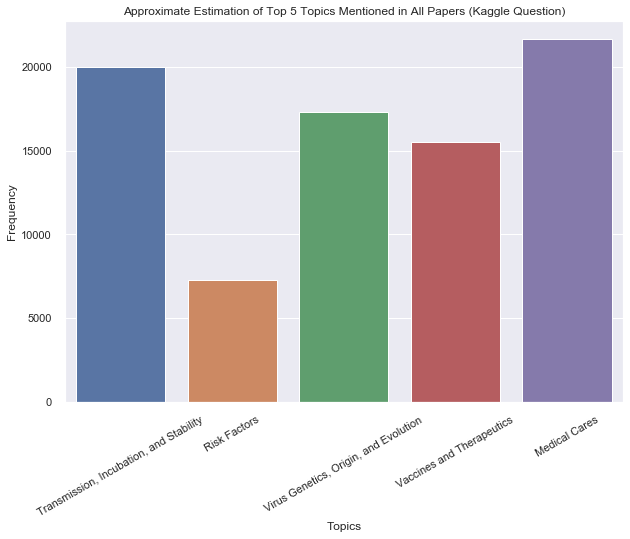

In [20]:
plt.figure(figsize=(10,7))
sns.barplot(x=list(topic_mentioned.keys()),y=list(topic_mentioned.values()))
plt.title('Approximate Estimation of Top 5 Topics Mentioned in All Papers (Kaggle Question)')
plt.xlabel('Topics')
plt.xticks(rotation=30)
plt.ylabel('Frequency')
plt.show()

### 2.5 Preliminary Insights on Risk Factors in Abstracts only

I explore more insights over the risk factors predefined in last section to see the proportion of each risk factor. From the Pie Chart, we can see the risk factors are distributed very unevenly in abstracts: 'pulmonary', 'social' and 'natals' are three risks factors that are mentioned most frequently among others in the papers. However, word frequency is not enough provide very useful insights on risk factors only in abstract sections, therefore, we need to dig more on the body texts in papers and see the importance of each factor.

In [21]:
risk_words = topics['Risk Factors']
risk_words.remove('risk')

In [22]:
risk_mentioned = dict((risk,0) for risk in risk_words)
for risk in risk_mentioned:
    for text in df['abstract']:
        if str(risk) in text:
            risk_mentioned[risk] += 1

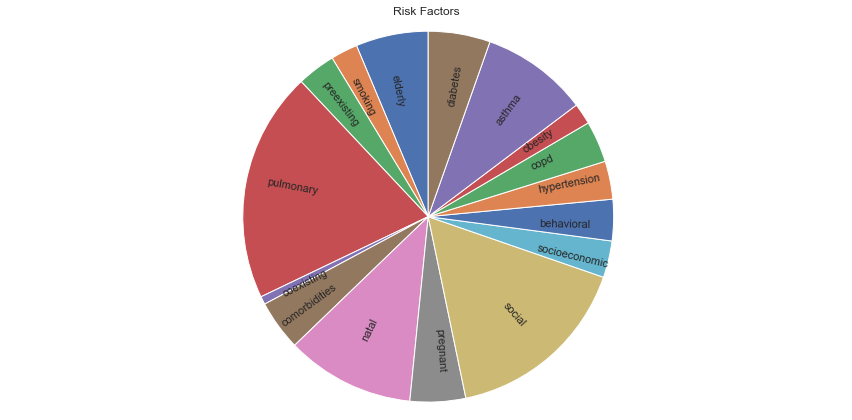

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
ax.pie(risk_mentioned.values(),labels=risk_mentioned.keys(),rotatelabels=True, labeldistance=0.6, pctdistance=0.5, startangle=90)
ax.axis('equal')
ax.set_title('Risk Factors')
fig.tight_layout()
plt.show()

# <center>3. Model Implementation<center>

### 3.1 Retrieval System for Papers Relevent to Risk Factors 

To dig more over the entire text, I built a retrieval system. This retrieval system used the research papers as database and will answer any queries related to viruses to help people get the most related papers. Doctors or research groups could use this system to extract relevant papers to **all topics they are interested to find out**, and they will not waste their time to going through every paper and get the basic understanding what this paper is talking about. They can just simply give the query and the system will automatically return top 10 papers related tothis query.


This system calculates the euclidean distance between queries and documents and sort the distances in ascending order to get top papers with smaller distances.


**this section mainly focuses on the papers relevant to risk factors**

##### 3.1.1 Get TFIDF Features for Entire Texts for Each Paper

In the following section, firstly I combined 'title', 'abstract' and 'body_text' into one column 'preprocessed' and did some cleaning over the entire text; then, I used CountVectorizer and TfidfTransformer to create the features over all texts from papers; finally, for each preprocessed text from each paper, same TfidfTransformer will be used to convert the text to features in sparse matrices and added to a new column called 'word_vector' (the dataset is then exported to 'finaldf.csv' just in case the kernel will restart...).

In [24]:
def combine(row):
    
    analyzer = CountVectorizer().build_analyzer()
    text = str.join(' ', [str(row['title']), str(row['abstract']), str(row['body_text'])])
    text = text.lower()
    text = str.join(" ", [lemmatizer.lemmatize(w) for w in analyzer(text)])
    
    return text

In [25]:
df['preprocessed'] = df.apply(lambda x: combine(x), axis=1)

In [26]:
cv = CountVectorizer(stop_words='english')
word_count = cv.fit_transform(df['preprocessed'])
tfidf_tr = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_tr.fit(word_count)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [27]:
df['word_vector'] = df['preprocessed'].apply(lambda x: tfidf_tr.transform(cv.transform([x])))

In [28]:
#df.to_csv('finaldf.csv')

##### 3.1.2 Retrieval System

After I got the features with tf-idf weighting scores for each paper, I start to build the retrieval system to get the papers relevent to risk factors. I copied the detailed questions inside the 'risk factor' task from Kaggle and the questions are summarized below in the 'tasks' list, these questions are used as queries to the retrieval system. Inside the retrieval function, the query is firstly cleaned and lemmatized, then same tfidf transformer will convert the query terms into sparse matrix with same shape, then the euclidean distance between the query and words features of paper are calculated and sorted with ascending distances. Finally, top 10 papers with smallest distances for each query is displayed and summarized into the list called 'topic_results'

In [29]:
# predifined tasks
tasks = ["Data on potential risks factors",
        "Smoking, pre-existing pulmonary disease",
        "Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities",
        "Neonates and pregnant women",
        "Social, economic and behavioral factors to understand the economic impact of the virus and whether there were differences.",
        "Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors",
        "Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups",
        "Susceptibility of populations",
        "Public health mitigation measures that could be effective for control"]

In [30]:
def get_relevant_papers(tasks,k):
    
    #function inside a function
    def get_distance(search_words_indices, search_vec, document_vector):
        
        document_vec = document_vector[0, search_words_indices].toarray()
        dist = euclidean(search_vec, document_vec)
        
        return dist
    
    topic_results = []
    
    #iterate over task inside the predifined list
    for topic in tasks:
        
        # same tf_idf transfrom the words in query
        analyzer = CountVectorizer().build_analyzer()
        lemmatizer = WordNetLemmatizer()
        text = topic.lower()
        text = str.join(" ", [lemmatizer.lemmatize(w) for w in analyzer(text)])
        query_vec = tfidf_tr.transform(cv.transform([text]))

        # get the indices for query
        query_indices = query_vec.indices
        search = query_vec[0,query_indices].toarray()

        # calculate distance for each instance
        distances = df.apply(lambda x: get_distance(query_indices, search, x['word_vector']), axis=1)

        # Get most similar papers (small distances)
        topk_papers = distances.sort_values().head(k).index  #top papers indices
        cols = ["title","authors",'abstract','preprocessed',"word_vector"]
        result = df[cols].iloc[topk_papers].fillna("")
        
        display(result) #print out returned papers and their information
        topic_results.append(result)
    
    return topic_results

In [31]:
topic_results = get_relevant_papers(tasks,k=10)

,title,authors,abstract,preprocessed,word_vector
664,Estimating the Risks from COVID-19 Infection i...,Matt Williams; Kerlann Le Calvez; Ella Mi; Jia...,"['sarscov2', 'covid19', 'novel', 'coronavirus'...",estimating the risk from covid 19 infection in...,"(0, 1072566)\t0.014431983871985764\n (0, 10..."
16389,Chapter 5 Role of risk analysis and risk commu...,"Attrey, D.P.","['abstract', 'concept', 'risk', 'analysis', 'f...",chapter role of risk analysis and risk communi...,"(0, 1077670)\t0.00427357296953192\n (0, 107..."
14739,When even the 'best-laid' plans go wrong,"McComas, Katherine","['strategic', 'risk', 'communication', 'new', ...",when even the best laid plan go wrong strategi...,"(0, 1078760)\t0.026058786642606874\n (0, 10..."
22652,Selection of critical factors for identifying ...,"van Asselt, E.D.; Meuwissen, M.P.M.; van Assel...","['abstract', 'proactive', 'emerging', 'risk', ...",selection of critical factor for identifying e...,"(0, 1072566)\t0.008771614763877557\n (0, 10..."
2582,How to make predictions about future infectiou...,"Woolhouse, Mark","['formal', 'quantitative', 'approach', 'widely...",how to make prediction about future infectious...,"(0, 1079945)\t0.010950293839345267\n (0, 10..."
9605,The influence of strain due to individual risk...,"Sung-Man, Bae","['suicide', 'outcome', 'interaction', 'biologi...",the influence of strain due to individual risk...,"(0, 1078047)\t0.005336504914593615\n (0, 10..."
9475,Exploring the Determinants of Perceived Risk o...,"Kim, Sunhee; Kim, Seoyong","['world', 'turning', 'risky', 'society', 'alth...",exploring the determinant of perceived risk of...,"(0, 1074627)\t0.0072904877715227094\n (0, 1..."
13986,The consequences of fear,"Ropeik, David","['modern', 'world', 'risky', 'place', 'evokes'...",the consequence of fear modern world risky pla...,"(0, 1077670)\t0.030290781396066436\n (0, 10..."
12921,Risk analysis for plant-made vaccines,"Kirk, Dwayne D.; McIntosh, Kim; Walmsley, Aman...","['production', 'vaccine', 'transgenic', 'plant...",risk analysis for plant made vaccine productio...,"(0, 1075541)\t0.01140871125722165\n (0, 107..."
5534,Risk Factors for Death from Influenza A(H1N1)p...,"Ribeiro, Ana Freitas; Pellini, Alessandra Cris...","['casecontrol', 'study', 'aimed', 'ass', 'risk...",risk factor for death from influenza h1n1 pdm0...,"(0, 1074627)\t0.00954719617547771\n (0, 107..."


,title,authors,abstract,preprocessed,word_vector
27354,"Effects of smoking and solid-fuel use on COPD,...","Lin, Hsien-Ho; Murray, Megan; Cohen, Ted; Coli...","['summary', 'background', 'chronic', 'obstruct...",effect of smoking and solid fuel use on copd l...,"(0, 1030211)\t0.009545114658985734\n (0, 10..."
26486,"Respiratory Medicine in China Progress, Challe...","Wang, Chen; Xiao, Fei; Qiao, Renli; Shen, Ying H.","['past', 'century', 'witnessed', 'rapid', 'dev...",respiratory medicine in china progress challen...,"(0, 1075293)\t0.015834403699274913\n (0, 10..."
1335,The Effectiveness of Contact Tracing in Emergi...,"Klinkenberg, Don; Fraser, Christophe; Heesterb...","['background', 'contact', 'tracing', 'play', '...",the effectiveness of contact tracing in emergi...,"(0, 1074737)\t0.026697648084588292\n (0, 10..."
21885,Clinical characteristics and outcome of ICU ad...,"Halim, Ashraf Abdel; Alsayed, Badr; Embarak, S...","['abstract', 'middle', 'east', 'respiratory', ...",clinical characteristic and outcome of icu adm...,"(0, 1074615)\t0.006288611558549932\n (0, 10..."
17008,COPD in China The Burden and Importance of Pro...,"Fang, Xiaocong; Wang, Xiangdong; Bai, Chunxue","['although', 'knowledge', 'exhaustive', 'credi...",copd in china the burden and importance of pro...,"(0, 1072566)\t0.027209751018917084\n (0, 10..."
12288,COVID-19 and smoking: A systematic review of t...,"Vardavas, Constantine I.; Nikitara, Katerina","['covid19', 'coronavirus', 'outbreak', 'initia...",covid 19 and smoking systematic review of the ...,"(0, 1078289)\t0.014390234701433429\n (0, 10..."
12769,"Drinking, Smoking, and Morality: Do ‘Drinkers ...","Møller, Valerie; Erstad, Ida; Zani, Dalinyebo","['paper', 'follows', 'unexpected', 'finding', ...",drinking smoking and morality do drinker and s...,"(0, 1080555)\t0.0064662777929335264\n (0, 1..."
9393,Correlation between Pneumonia Severity and Pul...,"Park, Wan Beom; Jun, Kang Il; Kim, Gayeon; Cho...","['nationwide', 'prospective', 'cohort', 'study...",correlation between pneumonia severity and pul...,"(0, 1072566)\t0.05864956443788344\n (0, 107..."
27166,Sex difference and smoking predisposition in p...,"Cai, Hua","['outbreak', 'novel', 'coronavirus', 'disease'...",sex difference and smoking predisposition in p...,"(0, 1078047)\t0.0751660647313085\n (0, 1074..."
17229,Environmental factors and their regulation of ...,"Koch, Marcus W.; Metz, Luanne M.; Agrawal, Smr...","['abstract', 'epidemiological', 'clinical', 's...",environmental factor and their regulation of i...,"(0, 1080067)\t0.014214764546936522\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
27249,Role of viral respiratory infections in asthma...,"Busse, William W; Lemanske, Robert F; Gern, Ja...","['summary', 'viral', 'respiratory', 'tract', '...",role of viral respiratory infection in asthma ...,"(0, 1072566)\t0.03336417698135695\n (0, 105..."
25041,iTRAQ-based comparative proteomic analysis of ...,"Guo, Xiaozhen; Hu, Han; Chen, Fangzhou; Li, Zh...","['abstract', 'reemerging', 'porcine', 'epidemi...",itraq based comparative proteomic analysis of ...,"(0, 1080307)\t0.025726595895923476\n (0, 10..."
14767,Eradicating infectious disease using weakly tr...,"Nuismer, Scott L.; Althouse, Benjamin M.; May,...","['viral', 'vaccine', 'remarkable', 'positive',...",eradicating infectious disease using weakly tr...,"(0, 1063516)\t0.006333401400375966\n (0, 10..."
16324,Chapter 1 The Human Toll of Viral Diseases Pas...,"Nathanson, Neal","['abstract', 'chapter', 'profile', 'example', ...",chapter the human toll of viral disease past p...,"(0, 1079949)\t0.06960600187659785\n (0, 107..."
9203,Enhanced Replication of Virulent Newcastle Dis...,"Zhang, Pingze; Ding, Zhuang; Liu, Xinxin; Chen...","['newcastle', 'disease', 'nd', 'caused', 'infe...",enhanced replication of virulent newcastle dis...,"(0, 1072745)\t0.003984509749055281\n (0, 10..."
24746,Viral respiratory infections in cystic fibrosis,"van Ewijk, Bart E.; van der Zalm, Marieke M.; ...","['abstract', 'viral', 'respiratory', 'infectio...",viral respiratory infection in cystic fibrosis...,"(0, 1076583)\t0.016446900631091665\n (0, 10..."
14698,Long-Term Care Facilities: A Cornucopia of Vir...,"Falsey, Ann R.; Dallal, Gerard E.; Formica, Ma...","['objective', 'determine', 'frequency', 'type'...",long term care facility cornucopia of viral pa...,"(0, 1074615)\t0.02136697699323301\n (0, 107..."
26013,"Complete genomic sequences, a key residue in t...","Zhang, Xinsheng; Hasoksuz, Mustafa; Spiro, Dav...","['abstract', 'transmissible', 'gastroenteritis...",complete genomic sequence key residue in the s...,"(0, 1047544)\t0.024737140788298327\n (0, 10..."
11290,Evolution and containment of transmissible rec...,"Nuismer, Scott L.; Basinski, Andrew; Bull, Jam...","['transmissible', 'vaccine', 'offer', 'revolut...",evolution and containment of transmissible rec...,"(0, 1079945)\t0.004954189856022056\n (0, 10..."
16688,28 New and Emerging Infections of the Lung,"Tambyah, Paul; Isa, Mas Suhaila; Tan, Christel...","['abstract', 'era', 'rapid', 'globalization', ...",28 new and emerging infection of the lung abst...,"(0, 1079949)\t0.0072207581332056296\n (0, 1..."


,title,authors,abstract,preprocessed,word_vector
8938,Pregnancy and infection: using disease pathoge...,"Vermillion, Meghan S.; Klein, Sabra L.","['vaccination', 'mainstay', 'preventative', 'm...",pregnancy and infection using disease pathogen...,"(0, 1080067)\t0.03020452130458174\n (0, 107..."
25831,Potential Maternal and Infant Outcomes from (W...,"Schwartz, David A.; Graham, Ashley L.","['early', 'december', '2019', 'cluster', 'case...",potential maternal and infant outcome from wuh...,"(0, 1079949)\t0.009756455813921948\n (0, 10..."
26358,Clinical characteristics and intrauterine vert...,"Chen, Huijun; Guo, Juanjuan; Wang, Chen; Luo, ...","['summary', 'background', 'previous', 'study',...",clinical characteristic and intrauterine verti...,"(0, 1078270)\t0.0628738988935401\n (0, 1075..."
3332,Emerging Infections and Pregnancy,"Jamieson, Denise J.; Theiler, Regan N.; Rasmus...","['key', 'component', 'response', 'emerging', '...",emerging infection and pregnancy key component...,"(0, 1072566)\t0.012332545807916397\n (0, 10..."
9132,Severe influenza A(H1N1)pdm09 in pregnant wome...,"Ribeiro, Ana Freitas; Pellini, Alessandra Cris...","['investigate', 'factor', 'associated', 'death...",severe influenza h1n1 pdm09 in pregnant woman ...,"(0, 1073118)\t0.010539828809363556\n (0, 10..."
3333,Prophylaxis and Treatment of Pregnant Women fo...,"Cono, Joanne; Cragan, Janet D.; Jamieson, Deni...","['emerging', 'infectious', 'disease', 'outbrea...",prophylaxis and treatment of pregnant woman fo...,"(0, 1076596)\t0.020904355627114443\n (0, 10..."
17064,Management guidelines for obstetric patients a...,"Maxwell, Cynthia; McGeer, Alison; Young Tai, K...","['abstract', 'objective', 'document', 'summari...",management guideline for obstetric patient and...,"(0, 1070133)\t0.017445287551201952\n (0, 10..."
24897,Management Guidelines for Obstetric Patients a...,"Maxwell, Cynthia; McGeer, Alison; Tai, Kin Fan...","['abstract', 'objective', 'document', 'summari...",management guideline for obstetric patient and...,"(0, 1070133)\t0.01663822307174614\n (0, 106..."
16588,Chapter 3 Immunobiological aspects of vaccines...,"Chu, Helen Y.; Marchant, Arnaud","['abstract', 'immunization', 'pregnancy', 'eff...",chapter immunobiological aspect of vaccine in ...,"(0, 1080067)\t0.014338837644475737\n (0, 10..."
26529,Psychological responses of pregnant women to a...,"Lee, Dominic T.S.; Sahota, Daljit; Leung, Tse ...","['abstract', 'objective', 'aim', 'present', 's...",psychological response of pregnant woman to an...,"(0, 1072566)\t0.008245981953092967\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
16054,Macroeconomic Effect of Infectious Disease Out...,"Keogh-Brown, M.R.","['abstract', 'article', 'highlight', 'importan...",macroeconomic effect of infectious disease out...,"(0, 1072566)\t0.018798983753426396\n (0, 10..."
18367,Assessment of economic vulnerability to infect...,"Sands, Peter; El Turabi, Anas; Saynisch, Phili...","['summary', 'infectious', 'disease', 'crisis',...",assessment of economic vulnerability to infect...,"(0, 1079949)\t0.0074876394764896315\n (0, 1..."
1924,The economy-wide impact of pandemic influenza ...,"Smith, Richard D; Keogh-Brown, Marcus R; Barne...","['objective', 'estimate', 'potential', 'econom...",the economy wide impact of pandemic influenza ...,"(0, 1073564)\t0.014295299603449208\n (0, 10..."
20592,Tourism expansion and economic development: Th...,"Kim, Hyun Jeong; Chen, Ming-Hsiang; Jang, SooC...","['abstract', 'study', 'examines', 'causal', 'r...",tourism expansion and economic development the...,"(0, 1077670)\t0.0044633408963967456\n (0, 1..."
2981,Systematic Review of Economic Evaluations of P...,"Pérez Velasco, Román; Praditsitthikorn, Naiyan...","['background', 'although', 'public', 'health',...",systematic review of economic evaluation of pr...,"(0, 1075182)\t0.017391960312969447\n (0, 10..."
19944,The economic impact of SARS: How does the real...,"Keogh-Brown, Marcus Richard; Smith, Richard David","['abstract', 'objective', 'perform', 'retrospe...",the economic impact of sars how doe the realit...,"(0, 1073555)\t0.007104975183861743\n (0, 10..."
16055,"Emerging Infections, the International Health ...","Heymann, D.L.; Reinhardt, K.","['abstract', 'breach', 'specie', 'barrier', 'a...",emerging infection the international health re...,"(0, 1072891)\t0.021380232218752623\n (0, 10..."
4977,How to Reduce the Latent Social Risk of Diseas...,"Ku-Yuan, Lee; Li-Chi, Lan; Jiun-Hao, Wang; Che...","['control', 'latent', 'social', 'risk', 'disea...",how to reduce the latent social risk of diseas...,"(0, 1073118)\t0.005139213000945778\n (0, 10..."
18551,ECONOMIC IMPACTS OF VISA RESTRICTIONS ON TOURI...,"Li, ShiNa; Song, Haiyan","['abstract', 'increasing', 'attention', 'paid'...",economic impact of visa restriction on tourism...,"(0, 1079660)\t0.00933375183081211\n (0, 107..."
7697,A Blueprint to Evaluate One Health,"Rüegg, Simon R.; McMahon, Barry J.; Häsler, Ba...","['one', 'health', 'oh', 'position', 'health', ...",blueprint to evaluate one health one health oh...,"(0, 1079949)\t0.011333553661178853\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
9808,Estimating human-to-human transmissibility of ...,"Zhang, Xu-Sheng; Iacono, Giovanni Lo","['hepatitis', 'caused', 'hepatitis', 'virus', ...",estimating human to human transmissibility of ...,"(0, 1074615)\t0.00614949663200083\n (0, 107..."
13492,Quantifying TB transmission: a systematic revi...,"Ma, Y.; Horsburgh, C. R.; White, L. F.; Jenkin...","['tuberculosis', 'tb', 'leading', 'global', 'i...",quantifying tb transmission systematic review ...,"(0, 1073971)\t0.0298368444705222\n (0, 1073..."
1457,Transmissibility of the Influenza Virus in the...,"White, Laura Forsberg; Pagano, Marcello","['background', 'heightened', 'increase', 'conc...",transmissibility of the influenza virus in the...,"(0, 1077670)\t0.010768948892683455\n (0, 10..."
4171,Estimating the reproductive number in the pres...,"White, Laura F; Archer, Brett; Pagano, Marcello","['background', 'estimate', 'parameter', 'disea...",estimating the reproductive number in the pres...,"(0, 1073558)\t0.009189467312205215\n (0, 10..."
11778,Spatially Adjusted Time-varying Reproductive N...,"Ng, Ta-Chou; Wen, Tzai-Hung","['basic', 'reproductive', 'number', 'r0', 'fun...",spatially adjusted time varying reproductive n...,"(0, 1079805)\t0.021845665914162617\n (0, 10..."
14158,Constructing Ebola transmission chains from We...,"PETTEY, W. B. P.; CARTER, M. E.; A TOTH, D. J....","['recent', 'ebola', 'crisis', 'west', 'africa'...",constructing ebola transmission chain from wes...,"(0, 1078477)\t0.026468033554764597\n (0, 10..."
27467,Epidemiological research priorities for public...,"Cowling, Benjamin J; Leung, Gabriel M","['infection', '2019ncov', 'spread', 'person', ...",epidemiological research priority for public h...,"(0, 1074299)\t0.03670669572687248\n (0, 107..."
27171,The Characteristics of Middle Eastern Respirat...,"Kim, Yunhwan; Lee, Sunmi; Chu, Chaeshin; Choe,...","['objective', 'outbreak', 'middle', 'eastern',...",the characteristic of middle eastern respirato...,"(0, 1030493)\t0.02779625117493048\n (0, 103..."
25623,The Benefits of Transmission Dynamics Models i...,"Wendelboe, Aaron M.; Grafe, Carl; Carabin, Hélène","['abstract', 'factor', 'associated', 'emergenc...",the benefit of transmission dynamic model in u...,"(0, 1079949)\t0.06030400742926689\n (0, 107..."
194,The role of absolute humidity on transmission ...,Wei Luo; Maimuna S Majumder; Dianbo Liu; Canel...,"['novel', 'coronavirus', 'covid19', 'identifie...",the role of absolute humidity on transmission ...,"(0, 1073558)\t0.014409641199746522\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
26384,Human infection with avian influenza A H7N9 vi...,"Yu, Hongjie; Cowling, Benjamin J; Feng, Luzhao...","['summary', 'background', 'characterisation', ...",human infection with avian influenza h7n9 viru...,"(0, 1045314)\t0.11745193194446976\n (0, 104..."
5534,Risk Factors for Death from Influenza A(H1N1)p...,"Ribeiro, Ana Freitas; Pellini, Alessandra Cris...","['casecontrol', 'study', 'aimed', 'ass', 'risk...",risk factor for death from influenza h1n1 pdm0...,"(0, 1074627)\t0.00954719617547771\n (0, 107..."
4699,Comparison of Patients Hospitalized With Influ...,"Wang, Chen; Yu, Hongjie; Horby, Peter W.; Cao,...","['background', 'influenza', 'ah7n9', 'virus', ...",comparison of patient hospitalized with influe...,"(0, 1077670)\t0.006818008360349496\n (0, 10..."
664,Estimating the Risks from COVID-19 Infection i...,Matt Williams; Kerlann Le Calvez; Ella Mi; Jia...,"['sarscov2', 'covid19', 'novel', 'coronavirus'...",estimating the risk from covid 19 infection in...,"(0, 1072566)\t0.014431983871985764\n (0, 10..."
6956,Hospitalization Risk Due to Respiratory Illnes...,"Gaio, Vânia; Nunes, Baltazar; Pechirra, Pedro;...","['background', 'recent', 'study', 'suggest', '...",hospitalization risk due to respiratory illnes...,"(0, 1074627)\t0.007274525599242558\n (0, 10..."
6148,Association of Higher MERS-CoV Virus Load with...,"Feikin, Daniel R.; Alraddadi, Basem; Qutub, Mo...","['middle', 'east', 'respiratory', 'syndrome', ...",association of higher mers cov virus load with...,"(0, 1074627)\t0.009325264423463004\n (0, 10..."
2229,Hospitalized adult patients with 2009 influenz...,"Xi, Xiuming; Xu, Yuan; Jiang, Li; Li, Ang; Dua...","['background', 'april', '2009', 'pandemic', 'i...",hospitalized adult patient with 2009 influenza...,"(0, 1075660)\t0.02120046290239027\n (0, 107..."
22496,Hematological and Biochemical Factors Predicti...,"Chang, Hsiao-Ling; Chen, Kow-Tong; Lai, Shu-Ku...","['backgroundpurpose', 'severe', 'acute', 'resp...",hematological and biochemical factor predictin...,"(0, 1074627)\t0.013870822700618552\n (0, 10..."
4986,Outcomes of Influenza A(H1N1)pdm09 Virus Infec...,"Lynfield, Ruth; Davey, Richard; Dwyer, Dominic...","['background', 'data', 'prospectively', 'plann...",outcome of influenza h1n1 pdm09 virus infectio...,"(0, 1077183)\t0.006541082567166337\n (0, 10..."
24419,Clinical predictors of mortality of Middle Eas...,"Alfaraj, Sarah H.; Al-Tawfiq, Jaffar A.; Assir...","['abstract', 'background', 'since', 'emergence...",clinical predictor of mortality of middle east...,"(0, 1074627)\t0.017142812040842666\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
26246,Genetic susceptibility to infectious diseases:...,"Burgner, David; Jamieson, Sarra E; Blackwell, ...","['summary', 'genetic', 'epidemiology', 'includ...",genetic susceptibility to infectious disease b...,"(0, 1037002)\t0.06998861901286234\n (0, 102..."
16040,Chapter 57 Genomic Approaches to the Host Resp...,"Shannon, M. Frances","['publisher', 'summary', 'need', 'better', 'un...",chapter 57 genomic approach to the host respon...,"(0, 1078047)\t0.032195363195664586\n (0, 10..."
13280,Ecogenomics of Respiratory Diseases of Public ...,"Garantziotis, Stavros; Schwartz, David A.","['geneenvironment', 'interaction', 'indisputab...",ecogenomics of respiratory disease of public h...,"(0, 1074627)\t0.00721895055574653\n (0, 107..."
336,Estimation of country-level basic reproductive...,Joe Hilton; Matt J Keeling,"['outbreak', 'novel', 'coronavirus', 'covid19'...",estimation of country level basic reproductive...,"(0, 1074627)\t0.048570146552827986\n (0, 10..."
2814,Immunogenetic Factors Associated with Severe R...,"Juno, Jennifer; Fowke, Keith R.; Keynan, Yoav","['following', '2009', 'h1n1', 'pandemic', 'ong...",immunogenetic factor associated with severe re...,"(0, 1079949)\t0.033614991906330105\n (0, 10..."
20208,Why Can't We Just Use PCR? The Role of Genotyp...,"Bard, Jennifer Dien; Lee, Francesca","['abstract', 'need', 'phenotypic', 'susceptibi...",why can we just use pcr the role of genotypic ...,"(0, 1079805)\t0.03370189601345027\n (0, 107..."
8129,Recurrent and Sustained Viral Infections in Pr...,"Ruffner, Melanie A.; Sullivan, Kathleen E.; He...","['viral', 'infection', 'commonplace', 'often',...",recurrent and sustained viral infection in pri...,"(0, 1080067)\t0.01668885453444507\n (0, 107..."
23783,"Host susceptibility to MERS-CoV infection, a r...","Ko, Jae-Hoon; Seok, Hyeri; Park, Ga Eun; Lee, ...","['abstract', 'evaluate', 'host', 'susceptibili...",host susceptibility to mers cov infection retr...,"(0, 1079805)\t0.19453391578901025\n (0, 106..."
18644,Functional polymorphisms of the CCL2 and MBL g...,"Tu, Xinyi; Chong, Wai Po; Zhai, Yun; Zhang, Ho...","['summary', 'objective', 'ass', 'association',...",functional polymorphism of the ccl2 and mbl ge...,"(0, 1073558)\t0.005485579106457271\n (0, 10..."
3538,Does genetic diversity limit disease spread in...,"King, K C; Lively, C M","['commonly', 'held', 'view', 'genetically', 'h...",doe genetic diversity limit disease spread in ...,"(0, 1078763)\t0.013941890437562911\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
1646,Public Response to Community Mitigation Measur...,"Blendon, Robert J.; Koonin, Lisa M.; Benson, J...","['report', 'result', 'national', 'survey', 'co...",public response to community mitigation measur...,"(0, 1024446)\t0.06603443459004862\n (0, 101..."
2755,Conceptualising the technical relationship of ...,"Häsler, Barbara; Howe, Keith S; Stärk, Kathari...","['background', 'surveillance', 'intervention',...",conceptualising the technical relationship of ...,"(0, 1079949)\t0.004132993667910552\n (0, 10..."
721,Window of Opportunity for Mitigation to Preven...,Sergei Maslov; Nigel Goldenfeld,"['estimate', 'growth', 'demand', 'icu', 'bed',...",window of opportunity for mitigation to preven...,"(0, 1077670)\t0.012062573492111976\n (0, 10..."
3253,A systematic review to identify areas of enhan...,"Prieto, Diana M; Das, Tapas K; Savachkin, Alex...","['background', 'recent', 'year', 'computer', '...",systematic review to identify area of enhancem...,"(0, 1073558)\t0.004592186112260419\n (0, 10..."
13276,Public health preparedness: a systems‐level ap...,"Moore, Spencer; Mawji, Al; Shiell, Alan; Nosew...","['public', 'health', 'emergency', 'preparednes...",public health preparedness system level approa...,"(0, 1072566)\t0.008129517562128047\n (0, 10..."
5555,Merging Economics and Epidemiology to Improve ...,"Perrings, Charles; Castillo-Chavez, Carlos; Ch...","['mathematical', 'epidemiology', 'one', 'oldes...",merging economics and epidemiology to improve ...,"(0, 1079945)\t0.01784185479389903\n (0, 107..."
27050,How will country-based mitigation measures inf...,"Anderson, Roy M; Heesterbeek, Hans; Klinkenber...","['happened', 'china', 'show', 'quarantine', 's...",how will country based mitigation measure infl...,"(0, 1072566)\t0.004824671297432962\n (0, 10..."
6283,Reassessing Biological Threats: Implications f...,"Galloway, Summer Elise; Petzing, Stephanie Rac...","['multiple', 'factor', 'ranging', 'globalizati...",reassessing biological threat implication for ...,"(0, 1079949)\t0.050390166522630384\n (0, 10..."
27467,Epidemiological research priorities for public...,"Cowling, Benjamin J; Leung, Gabriel M","['infection', '2019ncov', 'spread', 'person', ...",epidemiological research priority for public h...,"(0, 1074299)\t0.03670669572687248\n (0, 107..."
16104,4.25 Mitigation and Adaptation Strategies to R...,"Lawler, J.J.; Spencer, B.; Olden, J.D.; Kim, S...","['abstract', 'increasing', 'temperature', 'alt...",25 mitigation and adaptation strategy to reduc...,"(0, 1080024)\t0.021470176196858103\n (0, 10..."


##### 3.1.3 Keywords in the Relevant Papers

There are 10 papers returned for each query, and top 30 most common keywords in their abstracts are returned and shown in the word clouds below (I use abstracts here to save computation and also prevent noises from body texts). From the word clouds, we can clearly pick up some risk factors from each query and being used to further analysis. The keywords for risks from word clouds are summarized as ['elderly', "smoking", "natal", "pregnant","social", "socioeconomic" ,"copd", "pulmonary","asthma","diabetes"]; in addition, by web searching the risk factors from https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-at-higher-risk.html, people with 'hypertension' and 'obesity' have more risks to get infected by COVID-19, therefore, these two words  are added to the risk factors as well.

In summary, keywords found from top5 relevant papers for each query are : ['elderly', "smoking", "natal", "pregnant","social", 'socioeconomic' ,'hypertension','copd', 'obesity', "pulmonary",'asthma','diabetes'], they will be using to clustering analysis.

In [32]:
risk_common_words = []
for i in range(len(topic_results)):
    df_temp = topic_results[i]
    topic_abstract = topk(df_temp,k=30,col='abstract')
    keywords, count = map(list, zip(*topic_abstract))
    risk_common_words.append((' ').join(keywords))

In [33]:
titles = ['Potential Risk Factors', 'Smoking and Pre-existing Pulmoney Disease', 'Co-infections', 'Neonates and Pregnancy',
         'Socio-economic and Behaviooural', 'Virus Dynamics', 'Severity of Disease', 'Susceptibility of Populations', 
         'Public Health Mitigation']

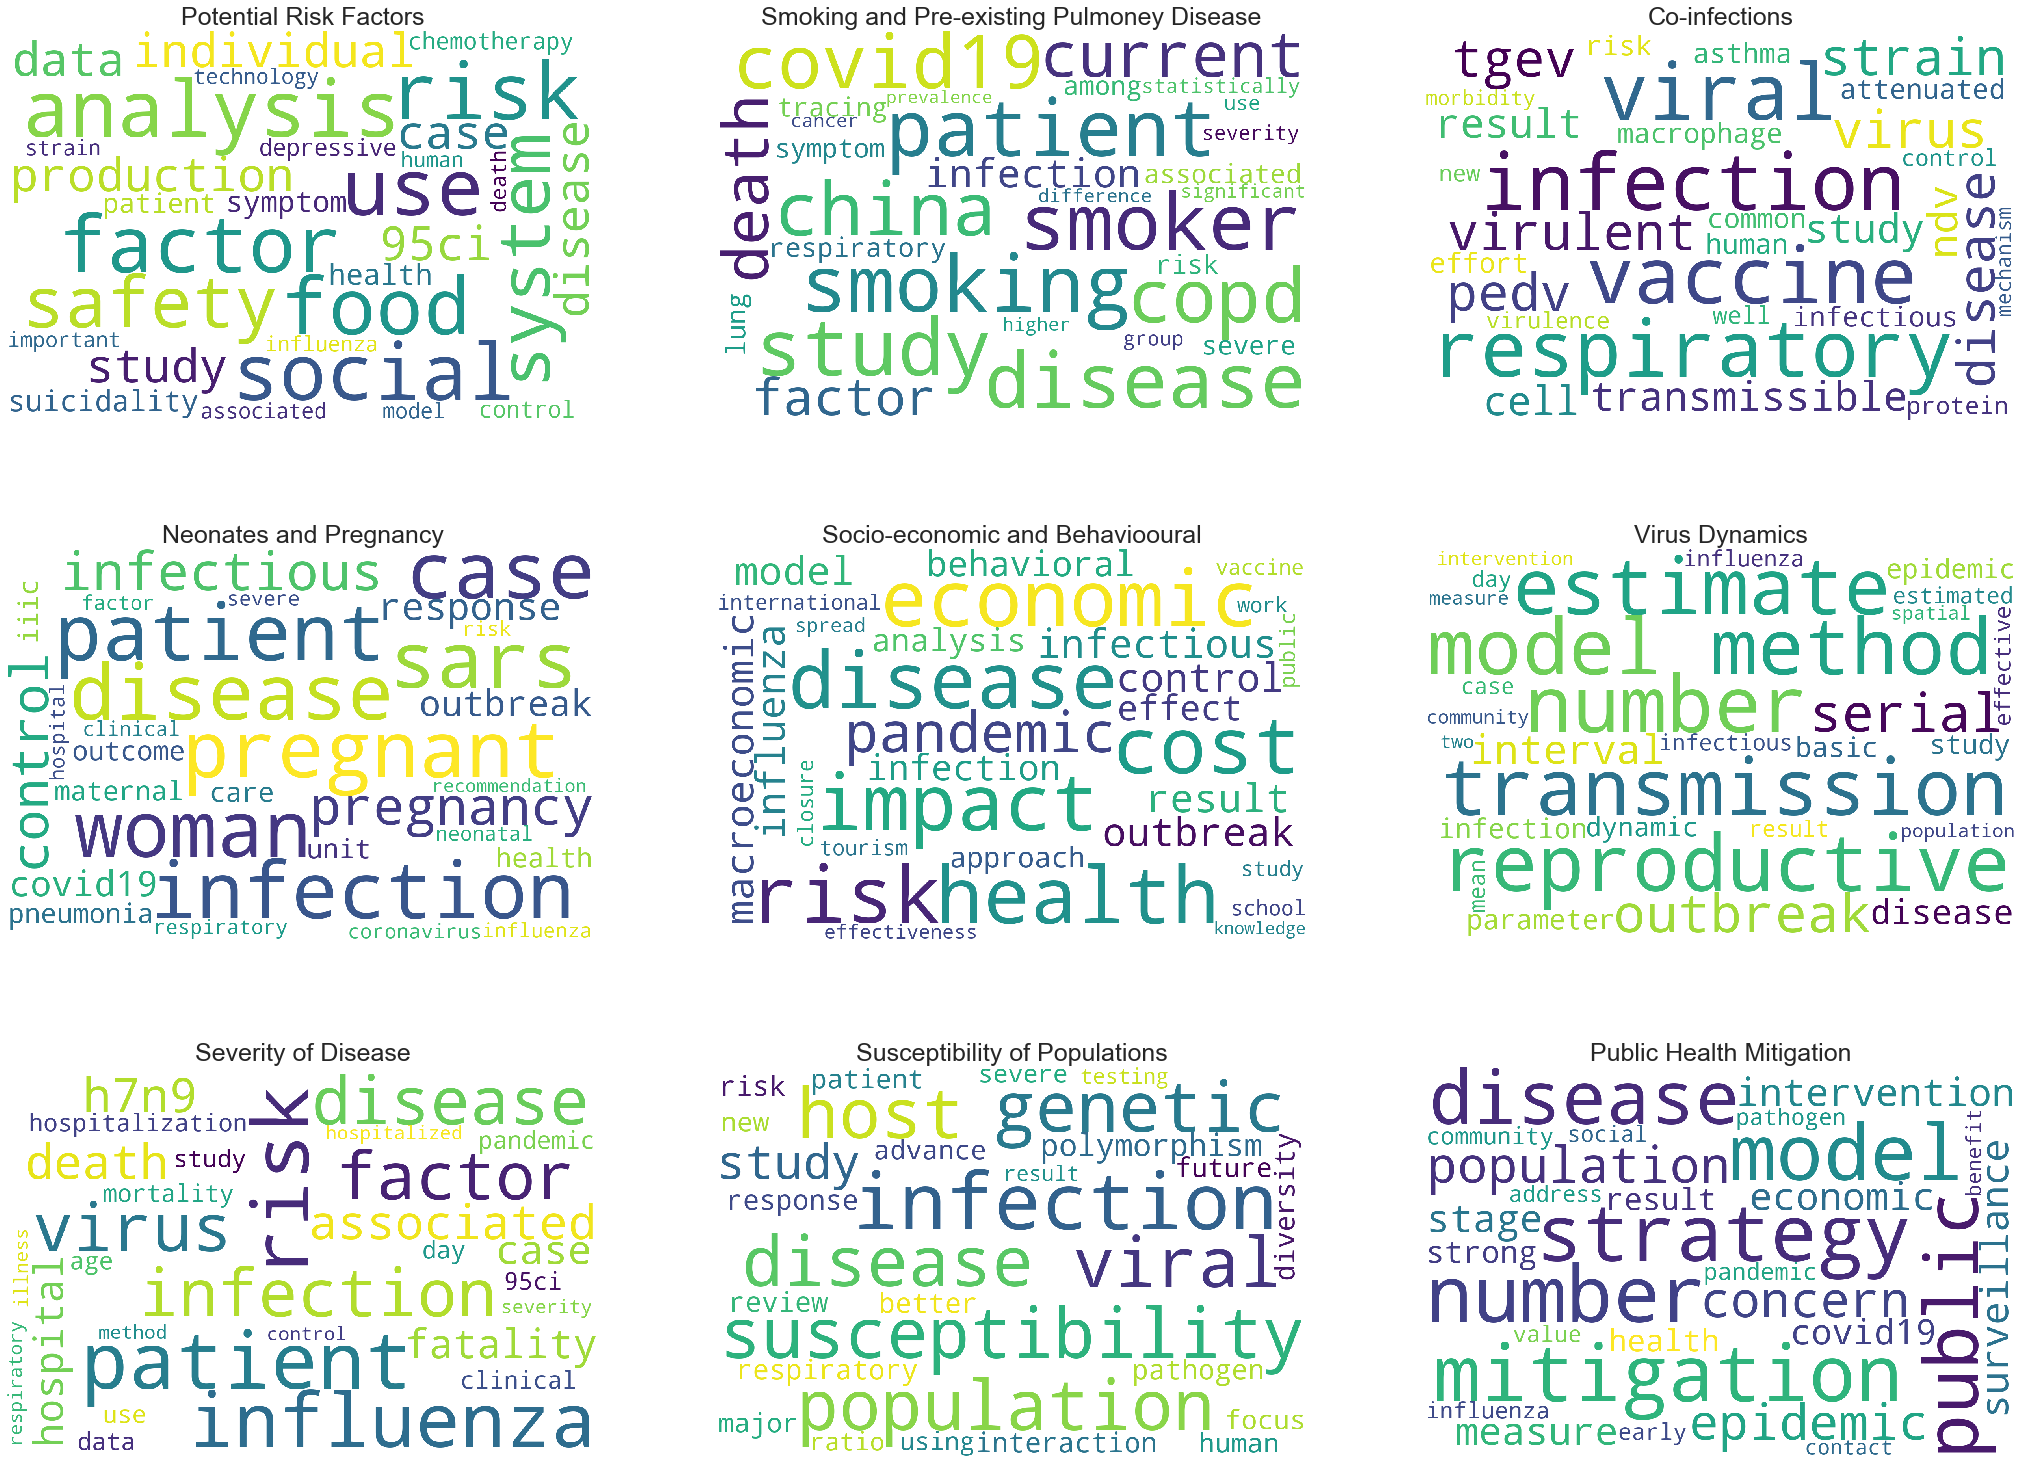

In [34]:
fig = plt.figure(figsize=(36,27))
for i in range(len(risk_common_words)):
    plt.subplot(3,3,i+1)
    sentence = risk_common_words[i]
    wordcloud = WordCloud(background_color="white",width=1500, height=1000,max_font_size=200,collocations=False).generate(sentence)
    plt.imshow(wordcloud)
    plt.title(titles[i],fontsize=25)
    plt.axis('off')

### 3.2 Hierarchical Clustering on Risk Factors

The reasons to do hierarchical clustering are: firstly, preliminarily get the clusters for all risk factors since many factors may have similar properties and will be clustered into same group and we can roughly interpret the reasonability and information behind the groups; secondly, to get more additional information about the risk factors such as other comorbidities may also appears with pre-defined risk factors, therefore, it is very useful to find most relevant papers from each cluster and see what those paper are talking about by extracting the keywords or key phrases to give the doctors or research group more insights and knowledge about these additional informations.

##### 3.2.1 Insights in Risk Factors from Entire Texts 

As discussed in the EDA section, primilinary exploratory analysis on risk factors in abstracts is not reliable and enough for me to compare the risk factors. Therefore, I used the pie chart again to show the distributions over the new risk factors as shown below. Admittedly, 'social' and 'pulmonary' are the two major sources of risks and they both occupied the largest proportions in the pie char; risks relevant to 'socioeconomic', 'neonatal', 'obesity', 'copd', 'hypertension' and 'asthma' have similar ratios as before; however, 'smoking', 'elderly', 'pregnant' and 'diabetes' are four risk factors appears more frequently when we look at the entire texts, therefore, they become more important. The importance of risk factors are summarized below in the pie chart as well since they are sorted.

In [35]:
risks = ['elderly', "smoking", "neonatal", "pregnant", "social", 'socioeconomic' ,'hypertension','copd',
         'obesity', "pulmonary",'asthma','diabetes']

In [36]:
risk_count = dict((risk,0) for risk in risks)

In [37]:
for risk in risk_count:
    for text in df['preprocessed']:
        if str(risk) in text:
            risk_count[risk] += 1

In [38]:
risk_count = {k: v for k, v in sorted(risk_count.items(), key=lambda item: item[1])}
risk_count

{'copd': 616,
 'obesity': 748,
 'smoking': 976,
 'hypertension': 1143,
 'socioeconomic': 1170,
 'pregnant': 1667,
 'neonatal': 1881,
 'asthma': 1941,
 'elderly': 2075,
 'diabetes': 2138,
 'social': 3774,
 'pulmonary': 4251}

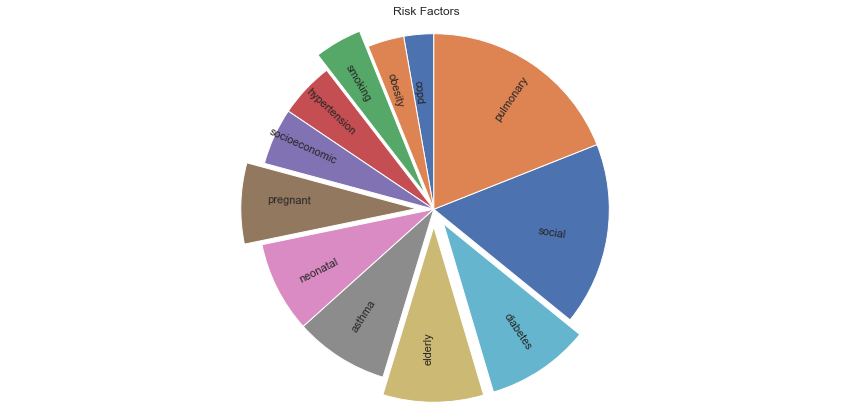

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
explode = (0,0,0.1,0,0,0.1,0,0,0.1,0.1,0,0)
ax.pie(risk_count.values(),labels=risk_count.keys(),rotatelabels=True, labeldistance=0.6, pctdistance=0.5, startangle=90,explode=explode)
ax.axis('equal')
ax.set_title('Risk Factors')
fig.tight_layout()
plt.show()

##### 3.2.2 Calculate Distance between each Risk Factor

To implement hierarchical clustering among all risk factors, a distance matrix is needed. Two similar risk factors will have smaller distance to each other. As given from the example, we can use the number of mentions in the entire texts rather than only abstracts and whether two risk factors appear in the same paper to get the distance between these two risk factors. If two keywords appear in the same texts, the distance is lowered, and the distance is getting bigger if they do appear separately in different documents. The distance matrix will have all 0s in the diagonal line and symmetric distances among all risk factors. (thankful for the example provided on Quercus).

In [40]:
#define the "distance" matrix used in the clustering
risk_dist = np.zeros((len(risks),len(risks)), dtype=float)
df_risks = pd.DataFrame(risk_dist, columns=risks, index=risks)

In [41]:
def cumulative_dist(risk1, risk2, df):
    
    cum_sum = 0
    number_of_papers = 0
    
    if risk1 == risk2: return 0
    
    for text in df['preprocessed']:
        
        if ((risk1 in text) and (risk2 in text)):
            number_of_papers += 1
            cum_sum -= 1
        
        elif (((risk1 in text) and (risk2 not in text)) or ((risk1 not in text) and (risk2 in text))):
            number_of_papers += 1
            cum_sum += 1

    return cum_sum/number_of_papers

In [42]:
risk_dist = np.zeros((len(risks),len(risks)), dtype=float)
for i in range(len(risks)):
    for j in range(len(risks)):
         risk_dist[i][j] = cumulative_dist(risks[i],risks[j], df)           

In [43]:
i = 0
for risk in risks:
    df_risks[risk] = np.power(risk_dist[i],5)
    i += 1
df_risks

,elderly,smoking,neonatal,pregnant,social,socioeconomic,hypertension,copd,obesity,pulmonary,asthma,diabetes
elderly,0.000000,0.363597,0.685160,0.322648,0.328297,0.427894,0.390617,0.416775,0.517749,0.191225,0.261220,0.228029
smoking,0.363597,0.000000,0.746183,0.560487,0.463535,0.389029,0.278069,0.173417,0.293630,0.325015,0.162132,0.265345
neonatal,0.685160,0.746183,0.000000,0.181656,0.639400,0.672746,0.659870,0.865696,0.638985,0.443522,0.605753,0.533605
pregnant,0.322648,0.560487,0.181656,0.000000,0.448829,0.555704,0.490375,0.806749,0.449949,0.387913,0.531900,0.346126
social,0.328297,0.463535,0.639400,0.448829,0.000000,0.164164,0.592173,0.819563,0.548798,0.436886,0.531858,0.394048
socioeconomic,0.427894,0.389029,0.672746,0.555704,0.164164,0.000000,0.606711,0.711030,0.529723,0.615012,0.504445,0.544697
hypertension,0.390617,0.278069,0.659870,0.490375,0.592173,0.606711,0.000000,0.477851,0.225051,0.257396,0.398639,0.024227
copd,0.416775,0.173417,0.865696,0.806749,0.819563,0.711030,0.477851,0.000000,0.639171,0.234663,0.112058,0.479967
obesity,0.517749,0.293630,0.638985,0.449949,0.548798,0.529723,0.225051,0.639171,0.000000,0.544012,0.416455,0.097383
pulmonary,0.191225,0.325015,0.443522,0.387913,0.436886,0.615012,0.257396,0.234663,0.544012,0.000000,0.064214,0.173774


##### 3.2.3 Clustering Risk Factors by Hierarchical Clustering and Dendrogram

We can see from the dendrogram, there are five clusters:

'social' and 'socioecnomic' factors are related to each other as they always appear together, economic is always mentioned when people are talking about social topics; 

'neonatal' and 'pregnant' are relevant to each other as well since new-born and pregnant women are always tied up'; 

'obesity', 'hypertension' and 'diabetes' are three comorbidities that likely to happen together;

From the wikipedia, *Chronic obstructive pulmonary disease (COPD) is a type of obstructive lung disease characterized by long-term breathing problems and poor airflow. The main symptoms include shortness of breath and cough with sputum production. COPD is a progressive disease, meaning it typically worsens over time. The most common cause of COPD is tobacco smoking, with a smaller number due to factors such as air pollution and genetics. In the developing world, one of the common sources of air pollution is poorly vented heating and cooking fires. Long-term exposure to these irritants causes an inflammatory response in the lungs, resulting in narrowing of the small airways and breakdown of lung tissue. The diagnosis is based on poor airflow as measured by lung function tests. In contrast to asthma, the airflow reduction does not improve much with the use of a bronchodilator.* Which we can see that 'copd' indeed has strong relationship with 'smoking' since it's a terrible disease mainly caused by overdosing on cigarettes;

Finally, 'pulmonary' and 'asthma' are two diseases related to lungs and therefore be clustered into one group, however, 'elderly' is also clustered into this group which makes little sense. From the dendrogram, we can see that the distance between 'elderly' and the cluster includes 'pulmonary' and 'asthma' is the largest which indicates that there is only a little relationship between these three factors: elderly may or may not have higher chance to get asthma and pulmonary.


(NOTE: To get the dendrogram successfully, sklearn package needs to be upgraded to 0.22.1 version)

In [44]:
#pip install scikit-learn==0.22.1

In [46]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

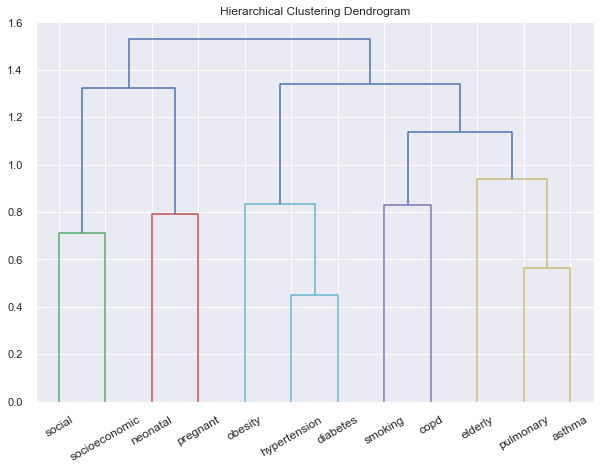

In [47]:
distance = np.power(risk_dist,2)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='complete')
model = model.fit(distance)

plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level',labels=risks,leaf_rotation=30)
plt.show()

### 3.3 K-Mean Clustering on Top 20 papers related to Each Risk Factor

After completing the clustering over 12 predefined risks, I ask myself this question: if the paper includes the risk factors predefined by me, does it also include some other risks similar to predefined ones but I missed? Therefore, to get more additional information about the risk factors, I decided to dig further over the papers that relevant to risks. 

To achieve this goal, I used K-mean model to further refine the clusters and group similar papers together to see the insights. From hirrarchical clustering, I can get the best number of clusters for K-mean and use it to do further analysis.

##### 3.3.1 Extract Relevant Papers for each Risk Factor

Before get into clustering of papers, I need to extract relevant papers to the risk factors only to eliminate noises. I used the predefined risk factors as queries to get top 20 papers by using the Retrieval System. There are 12 risks factors found by previous analysis and top 20 papers for each of them are extracted, therefore, a total number of 240 papers are combined together and ready for k-mean clustering.

In [48]:
#print out top 20 most relevant papers 
risk_docs = get_relevant_papers(risks,k=20)

,title,authors,abstract,preprocessed,word_vector
17367,Factors influencing seasonal influenza vaccina...,"Kan, T.; Zhang, J.","['abstract', 'objective', 'explore', 'behaviou...",factor influencing seasonal influenza vaccinat...,"(0, 1074627)\t0.01981084756188252\n (0, 107..."
24726,Lung infections and aging,"Meyer, Keith C.","['abstract', 'respiratory', 'tract', 'infectio...",lung infection and aging abstract respiratory ...,"(0, 1074627)\t0.06993780128903657\n (0, 107..."
26498,Prevalence and correlates of influenza vaccina...,"Lau, Lam; Lau, Ying; Lau, Ying Hon","['abstract', 'background', 'worldwide', 'pande...",prevalence and correlate of influenza vaccinat...,"(0, 1078787)\t0.0522084194693756\n (0, 1078..."
13416,Zinc: a new risk factor for pneumonia in the e...,"Barnett, Junaidah B.; Hamer, Davidson H.; Meyd...","['zinc', 'may', 'new', 'risk', 'factor', 'pneu...",zinc new risk factor for pneumonia in the elde...,"(0, 1078805)\t0.6739075506238447\n (0, 1074..."
2591,New Respiratory Viruses and the Elderly,"Jartti, Laura; Langen, Henriikka; Söderlund-Ve...","['diagnostics', 'respiratory', 'viral', 'infec...",new respiratory virus and the elderly diagnost...,"(0, 1076583)\t0.012816314704011138\n (0, 10..."
17463,The role of immunity in susceptibility to resp...,"Meyer, Keith C","['abstract', 'respiratory', 'tract', 'infectio...",the role of immunity in susceptibility to resp...,"(0, 1078805)\t0.012482299914134144\n (0, 10..."
22263,LOWER RESPIRATORY TRACT INFECTIONS IN ELDERLY ...,"Hunter, Alan J.; Bryant, Richard E.","['infection', 'play', 'significant', 'role', '...",lower respiratory tract infection in elderly p...,"(0, 1078872)\t0.011752306123981983\n (0, 10..."
12102,The profile of respiratory pathogens in induce...,"WARDZYŃSKA, ALEKSANDRA; PAWEŁCZYK, MAŁGORZATA;...","['introduction', 'respiratory', 'pathogen', 't...",the profile of respiratory pathogen in induced...,"(0, 1072566)\t0.019230920228870605\n (0, 10..."
5498,Viral Profile of COPD Exacerbations According ...,"Dimopoulos, G; Tsiodras, S; Lerikou, M; Chrani...","['background', 'compare', 'difference', 'elder...",viral profile of copd exacerbation according t...,"(0, 1074627)\t0.011959226352222917\n (0, 10..."
16361,Pneumonia,"Banu, Buyukaydin","['abstract', 'pneumonia', 'remains', 'main', '...",pneumonia abstract pneumonia remains main caus...,"(0, 1080067)\t0.009161038644739614\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
27354,"Effects of smoking and solid-fuel use on COPD,...","Lin, Hsien-Ho; Murray, Megan; Cohen, Ted; Coli...","['summary', 'background', 'chronic', 'obstruct...",effect of smoking and solid fuel use on copd l...,"(0, 1030211)\t0.009545114658985734\n (0, 10..."
17008,COPD in China The Burden and Importance of Pro...,"Fang, Xiaocong; Wang, Xiangdong; Bai, Chunxue","['although', 'knowledge', 'exhaustive', 'credi...",copd in china the burden and importance of pro...,"(0, 1072566)\t0.027209751018917084\n (0, 10..."
12288,COVID-19 and smoking: A systematic review of t...,"Vardavas, Constantine I.; Nikitara, Katerina","['covid19', 'coronavirus', 'outbreak', 'initia...",covid 19 and smoking systematic review of the ...,"(0, 1078289)\t0.014390234701433429\n (0, 10..."
12769,"Drinking, Smoking, and Morality: Do ‘Drinkers ...","Møller, Valerie; Erstad, Ida; Zani, Dalinyebo","['paper', 'follows', 'unexpected', 'finding', ...",drinking smoking and morality do drinker and s...,"(0, 1080555)\t0.0064662777929335264\n (0, 1..."
27166,Sex difference and smoking predisposition in p...,"Cai, Hua","['outbreak', 'novel', 'coronavirus', 'disease'...",sex difference and smoking predisposition in p...,"(0, 1078047)\t0.0751660647313085\n (0, 1074..."
17229,Environmental factors and their regulation of ...,"Koch, Marcus W.; Metz, Luanne M.; Agrawal, Smr...","['abstract', 'epidemiological', 'clinical', 's...",environmental factor and their regulation of i...,"(0, 1080067)\t0.014214764546936522\n (0, 10..."
20894,"The effect of smoking on influenza, influenza ...","Cruijff, Mark; Thijs, Carel; Govaert, Theofiel...","['abstract', 'examined', 'relation', 'cigarett...",the effect of smoking on influenza influenza v...,"(0, 1074627)\t0.004085879478498127\n (0, 10..."
21885,Clinical characteristics and outcome of ICU ad...,"Halim, Ashraf Abdel; Alsayed, Badr; Embarak, S...","['abstract', 'middle', 'east', 'respiratory', ...",clinical characteristic and outcome of icu adm...,"(0, 1074615)\t0.006288611558549932\n (0, 10..."
25681,Waterpipe smoking as a public health risk: Pot...,"Alagaili, Abdulaziz N.; Briese, Thomas; Amor, ...","['middle', 'east', 'respiratory', 'syndrome', ...",waterpipe smoking a public health risk potenti...,"(0, 1055320)\t0.77805925015477\n (0, 105491..."
8925,Estimates of global research productivity in u...,"Zyoud, Sa’ed H.","['background', 'tobacco', 'use', 'major', 'hea...",estimate of global research productivity in us...,"(0, 1077183)\t0.010991020704187247\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
2027,"New Approaches to Preventing, Diagnosing, and ...","Edmond, Karen; Zaidi, Anita","['karen', 'edmond', 'anita', 'zaidi', 'highlig...",new approach to preventing diagnosing and trea...,"(0, 1076344)\t0.020184633000479516\n (0, 10..."
8636,Innate Immunity to Respiratory Infection in Ea...,"Lambert, Laura; Culley, Fiona J.","['early', 'life', 'period', 'particular', 'sus...",innate immunity to respiratory infection in ea...,"(0, 1072745)\t0.009249691980492733\n (0, 10..."
15278,Serum antibody responses of neonatal and young...,"Stone, S.S.; Kemeny, L.J.; Jensen, M.T.","['abstract', 'serum', 'titer', 'virusneutraliz...",serum antibody response of neonatal and young ...,"(0, 1074615)\t0.1505710296879069\n (0, 1048..."
9183,Viral and bacterial investigations on the aeti...,"Mesonero-Escuredo, Susana; Strutzberg-Minder, ...","['background', 'neonatal', 'diarrhoea', 'repre...",viral and bacterial investigation on the aetio...,"(0, 1074615)\t0.007184582350917643\n (0, 10..."
1778,The impact on neonatal mortality of shifting c...,"Wang, Shi-Yi; Hsu, Sylvia H; Chen, Li-Kuei","['background', 'considerable', 'discussion', '...",the impact on neonatal mortality of shifting c...,"(0, 1072624)\t0.01932481680522797\n (0, 107..."
25308,Retrospective Biomolecular Investigation of Co...,"Stefanetti, Valentina; Compagnone, Agnese; Sor...","['abstract', 'abortion', 'neonatal', 'mortalit...",retrospective biomolecular investigation of co...,"(0, 1079949)\t0.02142170100001614\n (0, 107..."
24937,Pneumonia,"Hooven, Thomas A.; Polin, Richard A.","['abstract', 'neonatal', 'pneumonia', 'may', '...",pneumonia abstract neonatal pneumonia may occu...,"(0, 1073558)\t0.007336217722938009\n (0, 10..."
13065,Neonates Investigated for Influenza-Like Illne...,"Hon, Kam-lun Ellis; Cheung, Kam Lau; Wong, Wil...","['report', 'eight', 'case', 'neonate', 'birth'...",neonate investigated for influenza like illnes...,"(0, 1074631)\t0.03106418032494017\n (0, 106..."
26507,Antibody fusions reduce onset of experimental ...,"Imboden, Michael; Schaefer, Deborah A.; Bremel...","['abstract', 'cryptosporidium', 'parvum', 'one...",antibody fusion reduce onset of experimental c...,"(0, 1063516)\t0.0493815580962691\n (0, 1006..."
26949,Advax delta inulin adjuvant overcomes immune i...,"Honda-Okubo, Yoshikazu; Ong, Chun Hao; Petrovs...","['abstract', 'neonate', 'high', 'risk', 'influ...",advax delta inulin adjuvant overcomes immune i...,"(0, 1056541)\t0.02081843714117568\n (0, 104..."


,title,authors,abstract,preprocessed,word_vector
3332,Emerging Infections and Pregnancy,"Jamieson, Denise J.; Theiler, Regan N.; Rasmus...","['key', 'component', 'response', 'emerging', '...",emerging infection and pregnancy key component...,"(0, 1072566)\t0.012332545807916397\n (0, 10..."
26274,Clinical manifestations and outcome of SARS-Co...,"Liu, Yangli; Chen, Haihong; Tang, Kejing; Guo,...","['tang', 'colleague', 'journal', 'drew', 'read...",clinical manifestation and outcome of sars cov...,"(0, 1078108)\t0.08084664595745115\n (0, 107..."
25831,Potential Maternal and Infant Outcomes from (W...,"Schwartz, David A.; Graham, Ashley L.","['early', 'december', '2019', 'cluster', 'case...",potential maternal and infant outcome from wuh...,"(0, 1079949)\t0.009756455813921948\n (0, 10..."
3333,Prophylaxis and Treatment of Pregnant Women fo...,"Cono, Joanne; Cragan, Janet D.; Jamieson, Deni...","['emerging', 'infectious', 'disease', 'outbrea...",prophylaxis and treatment of pregnant woman fo...,"(0, 1076596)\t0.020904355627114443\n (0, 10..."
9132,Severe influenza A(H1N1)pdm09 in pregnant wome...,"Ribeiro, Ana Freitas; Pellini, Alessandra Cris...","['investigate', 'factor', 'associated', 'death...",severe influenza h1n1 pdm09 in pregnant woman ...,"(0, 1073118)\t0.010539828809363556\n (0, 10..."
8938,Pregnancy and infection: using disease pathoge...,"Vermillion, Meghan S.; Klein, Sabra L.","['vaccination', 'mainstay', 'preventative', 'm...",pregnancy and infection using disease pathogen...,"(0, 1080067)\t0.03020452130458174\n (0, 107..."
27413,Clinical and CT imaging features of the COVID-...,"Liu, Huanhuan; Liu, Fang; Li, Jinning; Zhang, ...","['abstract', 'background', 'ongoing', 'outbrea...",clinical and ct imaging feature of the covid 1...,"(0, 1074627)\t0.005641517312530985\n (0, 10..."
13311,Specific Immunoglobulin G Antibody Detected in...,"Jiang, Xiugao; Gao, Xing; Zheng, Han; Yan, Mei...","['specific', 'immunoglobulin', 'g', 'antibody'...",specific immunoglobulin antibody detected in u...,"(0, 1062916)\t0.1390193976315987\n (0, 1022..."
16588,Chapter 3 Immunobiological aspects of vaccines...,"Chu, Helen Y.; Marchant, Arnaud","['abstract', 'immunization', 'pregnancy', 'eff...",chapter immunobiological aspect of vaccine in ...,"(0, 1080067)\t0.014338837644475737\n (0, 10..."
26358,Clinical characteristics and intrauterine vert...,"Chen, Huijun; Guo, Juanjuan; Wang, Chen; Luo, ...","['summary', 'background', 'previous', 'study',...",clinical characteristic and intrauterine verti...,"(0, 1078270)\t0.0628738988935401\n (0, 1075..."


,title,authors,abstract,preprocessed,word_vector
23979,The emerging use of social media for health-re...,"Hagg, Emily; Dahinten, V. Susan; Currie, Leann...","['abstract', 'background', 'social', 'medium',...",the emerging use of social medium for health r...,"(0, 1078534)\t0.00977815799083744\n (0, 107..."
1645,Social Support and Response to AIDS and Severe...,"Nandi, Arijit; Tracy, Melissa; Aiello, Allison...","['negative', 'public', 'reaction', 'emerging',...",social support and response to aid and severe ...,"(0, 1074468)\t0.1121903734760555\n (0, 1072..."
20361,Social media and outbreaks of emerging infecti...,"Tang, Lu; Bie, Bijie; Park, Sung-Eun; Zhi, Degui","['background', 'public', 'often', 'turn', 'soc...",social medium and outbreak of emerging infecti...,"(0, 1078534)\t0.005169630832616393\n (0, 10..."
5620,Social Capital and Health-Protective Behavior ...,"Chuang, Ying-Chih; Huang, Ya-Li; Tseng, Kuo-Ch...","['healthprotective', 'behavior', 'receiving', ...",social capital and health protective behavior ...,"(0, 1074627)\t0.0059223147861404216\n (0, 1..."
12217,Social network theory in the behavioural scien...,"Krause, J.; Croft, D. P.; James, R.","['social', 'network', 'theory', 'made', 'major...",social network theory in the behavioural scien...,"(0, 1079860)\t0.007672070025345309\n (0, 10..."
915,Social history and exposure to pathogen signal...,Joaquin Sanz; Paul L. Maurizio; Noah Snyder-Ma...,"['abstractsocial', 'experience', 'important', ...",social history and exposure to pathogen signal...,"(0, 1074180)\t0.021031571153413968\n (0, 10..."
9605,The influence of strain due to individual risk...,"Sung-Man, Bae","['suicide', 'outcome', 'interaction', 'biologi...",the influence of strain due to individual risk...,"(0, 1078047)\t0.005336504914593615\n (0, 10..."
16503,Chapter 4 Social Media and Health Crisis Commu...,"Denecke, K.; Atique, S.","['abstract', 'reacting', 'public', 'health', '...",chapter social medium and health crisis commun...,"(0, 1074627)\t0.012028992263574654\n (0, 10..."
8866,Global trends in research related to social me...,"Zyoud, Sa’ed H.; Sweileh, Waleed M.; Awang, Ra...","['background', 'social', 'medium', 'defined', ...",global trend in research related to social med...,"(0, 1072891)\t0.013584284087205037\n (0, 10..."
16190,Chapter Eleven Communicating During a Public H...,"Haddow, George D.; Haddow, Kim S.","['communicating', 'public', 'health', 'crisis'...",chapter eleven communicating during public hea...,"(0, 1079764)\t0.02192678469565185\n (0, 107..."


,title,authors,abstract,preprocessed,word_vector
27091,Infectious disease and economics: The case for...,"Smith, Kristine M.; Machalaba, Catherine C.; S...","['beyond', 'public', 'health', 'impact', 'regi...",infectious disease and economics the case for ...,"(0, 1060066)\t0.12326577986325392\n (0, 105..."
23302,Canine parvovirus in Australia: The role of so...,"Brady, S.; Norris, J.M.; Kelman, M.; Ward, M.P.","['abstract', 'identify', 'cluster', 'canine', ...",canine parvovirus in australia the role of soc...,"(0, 1079949)\t0.005951623966093577\n (0, 10..."
14081,Avoidable mortality by neighbourhood income in...,"James, Paul D; Wilkins, Russell; Detsky, Allan...","['aim', 'examine', 'neighbourhood', 'income', ...",avoidable mortality by neighbourhood income in...,"(0, 1077183)\t0.006425716126009393\n (0, 10..."
13415,Communications in Public Health Emergency Prep...,"Savoia, Elena; Lin, Leesa; Viswanath, Kasisoma...","['public', 'health', 'crisis', 'public', 'heal...",communication in public health emergency prepa...,"(0, 1080812)\t0.016175782204000295\n (0, 10..."
10769,Impacts of Road Traffic Network and Socioecono...,"Xu, Bo; Tian, Huaiyu; Sabel, Clive Eric; Xu, Bing","['2009', 'pandemic', 'influenza', 'virus', 'ca...",impact of road traffic network and socioeconom...,"(0, 1077670)\t0.01020082856561038\n (0, 107..."
19507,"Socioeconomic, geographic and climatic risk fa...","Kelman, Mark; Barrs, Vanessa R.; Norris, Jacqu...","['abstract', 'infection', 'canid', 'canine', '...",socioeconomic geographic and climatic risk fac...,"(0, 1080105)\t0.04921894239867419\n (0, 107..."
25465,Urban-Rural Disparity in Helicobacter Pylori I...,"Wen, Xiaoduo; Wen, Denggui; Yang, Yi; Chen, Yu...","['abstract', 'background', 'globally', 'china'...",urban rural disparity in helicobacter pylorus ...,"(0, 1078289)\t0.004224634428632766\n (0, 10..."
25785,Prediction and prevention of the next pandemic...,"Morse, Stephen S; Mazet, Jonna AK; Woolhouse, ...","['summary', 'pandemicseg', 'hivaids', 'severe'...",prediction and prevention of the next pandemic...,"(0, 1079945)\t0.12006186447692813\n (0, 104..."
5974,Social determinants of health inequalities: to...,"Jayasinghe, Saroj","['system', 'approach', 'offer', 'novel', 'conc...",social determinant of health inequality toward...,"(0, 1072891)\t0.007905914068381462\n (0, 10..."
8139,Challenges in developing methods for quantifyi...,"Lo Iacono, Giovanni; Armstrong, Ben; Fleming, ...","['infectious', 'disease', 'attributable', 'uns...",challenge in developing method for quantifying...,"(0, 1072566)\t0.004345664556789296\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
11795,"Diabetes Mellitus, Hypertension, and Death amo...","Alanazi, Khalid H.; Abedi, Glen R.; Midgley, C...","['diabetes', 'mellitus', 'hypertension', 'reco...",diabetes mellitus hypertension and death among...,"(0, 1071857)\t0.03189256216575536\n (0, 106..."
13017,Biology of portal hypertension,"McConnell, Matthew; Iwakiri, Yasuko","['portal', 'hypertension', 'develops', 'result...",biology of portal hypertension portal hyperten...,"(0, 1073558)\t0.003936643234289636\n (0, 10..."
26316,Are patients with hypertension and diabetes me...,"Fang, Lei; Karakiulakis, George; Roth, Michael","['distinctive', 'comorbidities', '32', 'nonsur...",are patient with hypertension and diabetes mel...,"(0, 1072014)\t0.02210575905513304\n (0, 106..."
27355,Prevalence of comorbidities in the novel Wuhan...,"Yang, Jing; Zheng, Ya; Gou, Xi; Pu, Ke; Chen, ...","['abstract', 'background', 'outbreak', 'novel'...",prevalence of comorbidities in the novel wuhan...,"(0, 1078289)\t0.02281451557165768\n (0, 107..."
4953,From gene to protein—experimental and clinical...,"Patel, Sheila K.; Velkoska, Elena; Freeman, Me...","['hypertension', 'major', 'risk', 'factor', 's...",from gene to protein experimental and clinical...,"(0, 1080606)\t0.017851123418454094\n (0, 10..."
23432,The cat with neurological manifestations of sy...,"Kent, Marc","['practical', 'relevance', 'number', 'systemic...",the cat with neurological manifestation of sys...,"(0, 1074627)\t0.005991627771578607\n (0, 10..."
17171,Association of angiotensin-converting enzyme 2...,"Zhong, Jian; Yan, Zhengchen; Liu, Daoyan; Ni, ...","['establish', 'whether', 'angiotensinconvertin...",association of angiotensin converting enzyme g...,"(0, 1064080)\t0.01052223471135626\n (0, 106..."
27142,"ACE2, a promising therapeutic target for pulmo...","Shenoy, Vinayak; Qi, Yanfei; Katovich, Michael...","['pulmonary', 'arterial', 'hypertension', 'pah...",ace2 promising therapeutic target for pulmonar...,"(0, 1037535)\t0.10947507562098327\n (0, 103..."
26920,Stem cells and cell therapy approaches in lung...,"Sueblinvong, Viranuj; Weiss, Daniel J.","['cellbased', 'therapy', 'embryonic', 'adult',...",stem cell and cell therapy approach in lung bi...,"(0, 1047544)\t0.049281734535660614\n (0, 10..."
23636,Prevalence of comorbidities in the Middle East...,"Badawi, Alaa; Ryoo, Seung Gwan","['summary', 'middle', 'east', 'respiratory', '...",prevalence of comorbidities in the middle east...,"(0, 1079949)\t0.013982257432355448\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
17008,COPD in China The Burden and Importance of Pro...,"Fang, Xiaocong; Wang, Xiangdong; Bai, Chunxue","['although', 'knowledge', 'exhaustive', 'credi...",copd in china the burden and importance of pro...,"(0, 1072566)\t0.027209751018917084\n (0, 10..."
26293,COPD in Asia Where East Meets West,"Tan, Wan C.; Ng, Tze P.","['copd', 'global', 'health', 'concern', 'major...",copd in asia where east meet west copd global ...,"(0, 1077183)\t0.006261255104384609\n (0, 10..."
13110,Exacerbation of Chronic Obstructive Pulmonary ...,"Zhou, Xianghui; Li, Qingling; Zhou, Xincan","['chronic', 'obstructive', 'pulmonary', 'disea...",exacerbation of chronic obstructive pulmonary ...,"(0, 1072566)\t0.006430388655215549\n (0, 10..."
6598,Bacterial–viral load and the immune response i...,"D’Anna, Silvestro Ennio; Balbi, Bruno; Cappell...","['chronic', 'obstructive', 'pulmonary', 'disea...",bacterial viral load and the immune response i...,"(0, 1072566)\t0.0027098642043926033\n (0, 1..."
16887,Viral respiratory infections in elderly patien...,"Greenberg, Stephen B","['abstract', 'patient', 'chronic', 'obstructiv...",viral respiratory infection in elderly patient...,"(0, 1072566)\t0.045005706921200234\n (0, 10..."
25437,Chronic obstructive pulmonary disease in China...,"Fang, Liwen; Gao, Pei; Bao, Heling; Tang, Xun;...","['summary', 'background', 'rapid', 'change', '...",chronic obstructive pulmonary disease in china...,"(0, 1074627)\t0.009790469271707299\n (0, 10..."
13919,The influence of virus infections on the cours...,"Frickmann, H.; Jungblut, S.; Hirche, T. O.; Gr...","['chronic', 'obstructive', 'pulmonary', 'disea...",the influence of virus infection on the course...,"(0, 1072566)\t0.004713007532778447\n (0, 10..."
8447,The Relationship between Airway Inflammation a...,"Perng, Diahn-Warng; Chen, Pei-Ku","['chronic', 'obstructive', 'pulmonary', 'disea...",the relationship between airway inflammation a...,"(0, 1079423)\t0.008292695654944168\n (0, 10..."
26439,Chronic obstructive pulmonary disease subpopul...,"Segal, Leopoldo N.; Martinez, Fernando J.","['information', 'category', '1', 'cme', 'credi...",chronic obstructive pulmonary disease subpopul...,"(0, 1080565)\t0.015069884810389586\n (0, 10..."
1736,Systems biology coupled with label-free high-t...,"Richens, Joanna L; Urbanowicz, Richard A; Lunt...","['chronic', 'obstructive', 'pulmonary', 'disea...",system biology coupled with label free high th...,"(0, 1078047)\t0.0067347362737604395\n (0, 1..."


,title,authors,abstract,preprocessed,word_vector
10452,Influence of Obesity on Pneumococcus Infection...,"Frasca, Daniela; McElhaney, Janet","['obesity', 'negatively', 'affect', 'immune', ...",influence of obesity on pneumococcus infection...,"(0, 1074627)\t0.009136185530697357\n (0, 10..."
9008,Obesity and risk of respiratory tract infectio...,"Maccioni, Livia; Weber, Susanne; Elgizouli, Ma...","['background', 'respiratory', 'tract', 'infect...",obesity and risk of respiratory tract infectio...,"(0, 1077670)\t0.007002734112006176\n (0, 10..."
11929,Mechanistic Insight of Na/K-ATPase Signaling a...,"Pratt, Rebecca; Lakhani, Hari Vishal; Zehra, M...","['obesity', 'multifaceted', 'pathophysiologica...",mechanistic insight of na atpase signaling and...,"(0, 1072566)\t0.0016849022757524919\n (0, 1..."
10220,"Underweight, overweight, and obesity as indepe...","Moser, Joe‐Ann S.; Galindo‐Fraga, Arturo; Orti...","['background', 'relationship', 'obesity', 'ris...",underweight overweight and obesity a independe...,"(0, 1080307)\t0.026898192809596537\n (0, 10..."
17321,Urbanization and International Trade and Inves...,"Schram, Ashley; Labonté, Ronald; Sanders, David","['three', 'dominant', 'globalization', 'pathwa...",urbanization and international trade and inves...,"(0, 1078763)\t0.0067192390311224615\n (0, 1..."
16074,"Chapter 6 Public Health, Communicable Diseases...","Trent, Ronald J","['public', 'health', 'professional', 'consider...",chapter public health communicable disease and...,"(0, 1079949)\t0.004661476375122804\n (0, 10..."
23636,Prevalence of comorbidities in the Middle East...,"Badawi, Alaa; Ryoo, Seung Gwan","['summary', 'middle', 'east', 'respiratory', '...",prevalence of comorbidities in the middle east...,"(0, 1079949)\t0.013982257432355448\n (0, 10..."
12077,Overnutrition in Infants Is Associated With Hi...,"Arias-Bravo, Guisselle; Valderrama, Gustavo; I...","['objective', 'investigate', 'relationship', '...",overnutrition in infant is associated with hig...,"(0, 1080309)\t0.11321724122899861\n (0, 108..."
10719,Temporal trends in the incidence and demograph...,"Herzallah, Hatem K.; Antonisamy, Belavendra R....","['objective', 'describe', 'trend', 'incidence'...",temporal trend in the incidence and demographi...,"(0, 1080067)\t0.011130980920097613\n (0, 10..."
9126,A pilot study on primary cultures of human res...,"Huang, Chung-Guei; Lee, Li-Ang; Wu, Yi-Cheng; ...","['avian', 'influenza', 'ah7n9', 'virus', 'infe...",pilot study on primary culture of human respir...,"(0, 1074627)\t0.005963405155083021\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
5910,Pulmonary Function and Clinical Manifestations...,"Liu, Wei; Peng, Liping; Liu, Hongmei; Hua, Shu...","['objective', 'investigate', 'longterm', 'effe...",pulmonary function and clinical manifestation ...,"(0, 1077670)\t0.02294450624304132\n (0, 107..."
5359,Pulmonary vascular dysfunction in ARDS,"Ryan, Donal; Frohlich, Stephen; McLoughlin, Paul","['acute', 'respiratory', 'distress', 'syndrome...",pulmonary vascular dysfunction in ards acute r...,"(0, 1079805)\t0.00444543775060008\n (0, 107..."
13107,Pulmonary complications after T-cell-depleted ...,"Huisman, C; van der Straaten, H M; Canninga-va...","['lung', 'injury', 'limit', 'success', 'alloge...",pulmonary complication after cell depleted all...,"(0, 1072566)\t0.003980623437537536\n (0, 10..."
8114,Pulmonary infections in the returned traveller,"Trimble, Ashleigh; Moffat, V.; Collins, A. M.","['pulmonary', 'infection', 'returned', 'travel...",pulmonary infection in the returned traveller ...,"(0, 1079949)\t0.022888479252745696\n (0, 10..."
25353,Hematologic neoplasms: Interpreting lung findi...,"Calvillo Batllés, P.; Carreres Polo, J.; Sanz ...","['abstract', 'lung', 'disease', 'common', 'pat...",hematologic neoplasm interpreting lung finding...,"(0, 1073555)\t0.006119494932694162\n (0, 10..."
2614,"Demographic, etiological, and histological pul...","de Matos Soeiro, Alexandre; Ruppert, Aline D; ...","['introduction', 'acute', 'respiratory', 'fail...",demographic etiological and histological pulmo...,"(0, 1078437)\t0.03441120364390431\n (0, 107..."
7064,Pulmonary melanoma and “crazy paving” patterns...,"Feng, Yikuan; Zhao, Jianping; Yang, Qun; Xiong...","['background', 'lung', 'melanoma', 'mostly', '...",pulmonary melanoma and crazy paving pattern in...,"(0, 1080926)\t0.02470986895344873\n (0, 107..."
16780,Chapter 6 Respiratory Tract,"Greaves, Peter","['describes', 'pathology', 'found', 'respirato...",chapter respiratory tract describes pathology ...,"(0, 1079805)\t0.027860839798384225\n (0, 10..."
25639,1-Year Pulmonary Function and Health Status in...,"Ong, Kian-Chung; Ng, Alan Wei-Keong; Lee, Lawr...","['study', 'objective', 'characterize', 'longte...",year pulmonary function and health status in s...,"(0, 1074458)\t0.019833078065534117\n (0, 10..."
15812,VACCINATIONS | Viral,"Olszewska, W.; Openshaw, P.J.M.; Helson, R.","['vaccine', 'preparation', 'weakened', 'killed...",vaccination viral vaccine preparation weakened...,"(0, 1074627)\t0.011042646358122434\n (0, 10..."


,title,authors,abstract,preprocessed,word_vector
13049,Asthma in Children and Adolescents: A Comprehe...,"Chang, Christopher","['asthma', 'chronic', 'disease', 'significant'...",asthma in child and adolescent comprehensive a...,"(0, 1079805)\t0.00286106714718403\n (0, 107..."
8028,"Infection-mediated asthma: etiology, mechanism...","Webley, Wilmore C.; Hahn, David L.","['asthma', 'chronic', 'respiratory', 'disease'...",infection mediated asthma etiology mechanism a...,"(0, 1074615)\t0.0034330291271553377\n (0, 1..."
27525,Viruses and asthma,"Dulek, Daniel E.; Peebles, R. Stokes","['abstract', 'background', 'viral', 'respirato...",virus and asthma abstract background viral res...,"(0, 1074627)\t0.00972169746007335\n (0, 107..."
6103,No Direct Association Between Asthma and the M...,"Yayan, Josef","['current', 'us', 'cultureindependent', 'tool'...",no direct association between asthma and the m...,"(0, 1073100)\t0.009866458042111167\n (0, 10..."
16139,Chapter 28 Asthma,"Shaw, Dominick; Portelli, Michael; Sayers, Ian","['abstract', 'asthma', 'common', 'respiratory'...",chapter 28 asthma abstract asthma common respi...,"(0, 1080133)\t0.010740207042945786\n (0, 10..."
12140,Role of viruses in asthma,"Jartti, Tuomas; Bønnelykke, Klaus; Elenius, Va...","['respiratory', 'viral', 'infection', 'importa...",role of virus in asthma respiratory viral infe...,"(0, 1074627)\t0.00456863483063469\n (0, 107..."
27249,Role of viral respiratory infections in asthma...,"Busse, William W; Lemanske, Robert F; Gern, Ja...","['summary', 'viral', 'respiratory', 'tract', '...",role of viral respiratory infection in asthma ...,"(0, 1072566)\t0.03336417698135695\n (0, 105..."
18168,6. Asthma,"Lemanske, Robert F.; Busse, William W.","['abstract', 'increasing', 'incidence', 'preva...",asthma abstract increasing incidence prevalenc...,"(0, 1079805)\t0.003950255659744704\n (0, 10..."
23227,Asthma and viral infections An intricate relat...,"Mikhail, Irene; Grayson, Mitchell H.","['abstract', 'objective', 'synthesize', 'avail...",asthma and viral infection an intricate relati...,"(0, 1074627)\t0.00962842832827214\n (0, 107..."
18179,Prevalence of viral respiratory tract infectio...,"Khetsuriani, Nino; Kazerouni, N. Neely; Erdman...","['background', 'previous', 'study', 'support',...",prevalence of viral respiratory tract infectio...,"(0, 1074627)\t0.01287239980680988\n (0, 107..."


,title,authors,abstract,preprocessed,word_vector
10421,The double burden of diabetes and global infec...,"Dunachie, Susanna; Chamnan, Parinya","['four', 'five', 'people', 'world', 'diabetes'...",the double burden of diabetes and global infec...,"(0, 1080067)\t0.007837298388863139\n (0, 10..."
25446,The global diabetes epidemic: what does it mea...,"van Crevel, Reinout; van de Vijver, Steven; Mo...","['summary', 'tropical', 'country', 'experienci...",the global diabetes epidemic what doe it mean ...,"(0, 1080980)\t0.01058992178598624\n (0, 108..."
23692,The burden of type 2 diabetes: are we doing en...,"Zimmet, P.","['summary', 'increasing', 'level', 'obesity', ...",the burden of type diabetes are we doing enoug...,"(0, 1078793)\t0.03354027723702528\n (0, 107..."
12051,Secular trends in incidence of type 1 and type...,"Luk, Andrea O. Y.; Ke, Calvin; Lau, Eric S. H....","['background', 'limited', 'data', 'time', 'tre...",secular trend in incidence of type and type di...,"(0, 1078108)\t0.006005496931147252\n (0, 10..."
10412,Identification of Potential Type II Diabetes i...,"Pei, Dongmei; Zhang, Chengpu; Quan, Yu; Guo, Q...","['background', 'diabetes', 'mellitus', 'chroni...",identification of potential type ii diabetes i...,"(0, 1077183)\t0.011188599819775597\n (0, 10..."
5463,"Unrealistic Optimism, Sex, and Risk Perception...","Reyes-Velázquez, Wanda; Sealey-Potts, Claudia","['study', 'examined', 'link', 'among', 'unreal...",unrealistic optimism sex and risk perception o...,"(0, 1074737)\t0.03023855275458609\n (0, 107..."
24438,Physiological Outcomes of an Internet Disease ...,"Tjam, Erin Y.; Sherifali, Diana; Steinacher, N...","['abstract', 'objective', 'compare', 'physiolo...",physiological outcome of an internet disease m...,"(0, 1074615)\t0.005566653511285719\n (0, 10..."
26980,The sweeter side of ACE2: Physiological eviden...,"Bindom, Sharell M.; Lazartigues, Eric","['abstract', 'diabetes', 'mellitus', 'growing'...",the sweeter side of ace2 physiological evidenc...,"(0, 1063444)\t0.0305029541472627\n (0, 1017..."
7554,Prevalence of Diabetes in the 2009 Influenza A...,"Badawi, Alaa; Ryoo, Seung Gwan","['past', 'two', 'decade', 'number', 'severe', ...",prevalence of diabetes in the 2009 influenza h...,"(0, 1074627)\t0.03196856363982602\n (0, 107..."
11344,Viruses and Autoimmunity: A Review on the Pote...,"Smatti, Maria K.; Cyprian, Farhan S.; Nasralla...","['long', 'time', 'virus', 'shown', 'modify', '...",virus and autoimmunity review on the potential...,"(0, 1078664)\t0.015654022057452158\n (0, 10..."


In [49]:
#combine 12 dataframes into single one
df_risk_doc = pd.DataFrame()
for i in range(len(risk_docs)):
    df_risk_doc = df_risk_doc.append(risk_docs[i])

##### 3.3.2 Build K-mean Model

Same as before, I used TF-IDF to process the words over the entire texts of each paper ('preprocessed' column) and formalized features for K-mean. As hierarchical clustering model says, there are possibly 5 clusters over all risk factors and therefore, the predefined number of clusters is 5 and ready to fit into K-mean model.

In [50]:
tfvec = TfidfVectorizer(use_idf=True, smooth_idf=True, analyzer='word')
model_array = tfvec.fit_transform(df_risk_doc.preprocessed.values)

In [52]:
cluster = KMeans(n_clusters=5)
pred = cluster.fit_predict(model_array) #get clusters

##### 3.3.3 Visualize the Clusters in K-mean by T-SNE

I used T-SNE tool to visualize the cluters, TSNE can reduce the dimensionality of model with tons of features to 2-Dimension and allow us to visualize it in a 2D diagram. We can see cluster 1, 3 and 4 have very distinct structures and other two are mixed together. This may induce a problem in the model which cluster 2 and 5 may share similar information and will not have specific topics.(prove later)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 240 samples in 0.121s...
[t-SNE] Computed neighbors for 240 samples in 2.570s...
[t-SNE] Computed conditional probabilities for sample 240 / 240
[t-SNE] Mean sigma: 0.252164
[t-SNE] KL divergence after 250 iterations with early exaggeration: 22.452442
[t-SNE] KL divergence after 1000 iterations: 0.682302


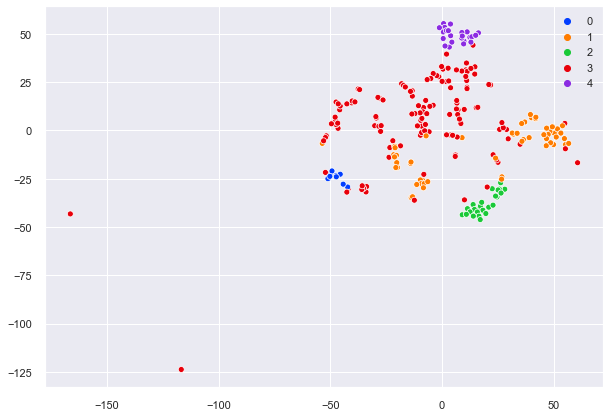

In [53]:
tsne = TSNE(verbose=True, perplexity=5, metric='euclidean',early_exaggeration=5)

model_array_embedded = tsne.fit_transform(model_array.toarray())

sns.set(rc={'figure.figsize':(10,7)})
color = sns.color_palette('bright',len(set(pred)))
sns.scatterplot(model_array_embedded[:,0],model_array_embedded[:,1], hue=pred, palette=color)
plt.show()

##### 3.3.4 Visualize Key Terms in Clusters

Similar to the analysis before, I focused on the top 20 single keywords and noun phrases appeared in papers from individual clusters. I used word clouds to visualize top 20 single words and bar plots for noun phrases. To generate interpretations for each cluster, we need to combine both single words and phrases and ignore some common terms such as 'diseases', 'infection', 'viral' etc. since they appear frequently for every cluster and will not provide any additional useful information for us. The interpretations are summarized as follows:

- Cluster 1: This cluster is talking about comorbidities to the coronavirus which includes risk factors 'diabetes' and 'hypertension'. It seems like some other comorbidities appeared in this cluster as well such as 'blood', 'kidney', 'ace2', 'renal disease' and 'cerebrovascular disease'. By searching these diseases, I found there are some sayings about these diseases have higher risks to get infected. It is also to mention that, as we can see from the noun phrases, 'infection covid19' appears frequently in this cluster which may indicate that people with these diseases are more likely to get infected by covid-19, therefore, these frequent terms are some potential risk factors;

- Cluster 2: This cluster is clearly focusing on 'social' factor which includes terms like 'social', 'social medium', 'social network', 'population', 'government'; 'cardiac disease', 'cardiovascular disease' are also appears very frequently which may indicate these two are also potential risk factors;

- Cluster 3: This cluster is mainly talking about the risk factors 'copd' and 'smoking' since terms 'COPD', 'smoking', 'lung', 'copd patient', 'cigarette smoke', 'airway inflammation' appeared very frequently here. These two factors are very related to each other since smoking is the major source of copd as we discussed before. 'men women' also appears which may imply gender could also be a risk factor;

- Cluster 4: This cluster mainly focuses on the papers talking about 'woman', 'pregant', 'gestation', 'elderly people','pregnant woman', 'year age' and 'age group','pulmonary'. We can therefore interpret this cluster as risk factors with 'pregnant', 'neonatal' ,'elderly', and 'pulmonary'.'influenza' is mentioned quite often and may be considered as a risk factor as well;

- Cluster 5: This cluster is likely to mix some risk factor together. It mainly includes risk factor 'asthma', some other words like 'child', 'age group', 'pregnant woman' indicates that risk factor appeared in cluster 4 are also here.


As results, Cluster 1 and Cluster 3 are two clusters with distinct information which matches the risk factors, however, other three clusters are kind of mixing up together. As the T-SNE graph shows, these three cluster do mix up together to share some information but 1 and 3 have relatively clear structures.

As we discussed before, some other risk factors may also be relevant to the pre-defined one. And K-mean model indeed proves this. The risk factors are mostly related to comorbidities such as 'blood', 'kidney', 'ace2', 'renal disease', 'cerebrovascular disease', 'cardiac disease', 'cardiovascular disease', 'influenza' and 'gender' are very relevant to these predefined factors and could be used to inform people to get ready earlier and reduce risks.

In [54]:
df_risk_doc['cluster'] = pred

- Top 20 Single Words from Each Cluster

In [55]:
cluster_word = []
for i in range(5):
    df_c = df_risk_doc[df_risk_doc.cluster==i]
    cluster_word.append(topk(df_c, 30, 'preprocessed'))

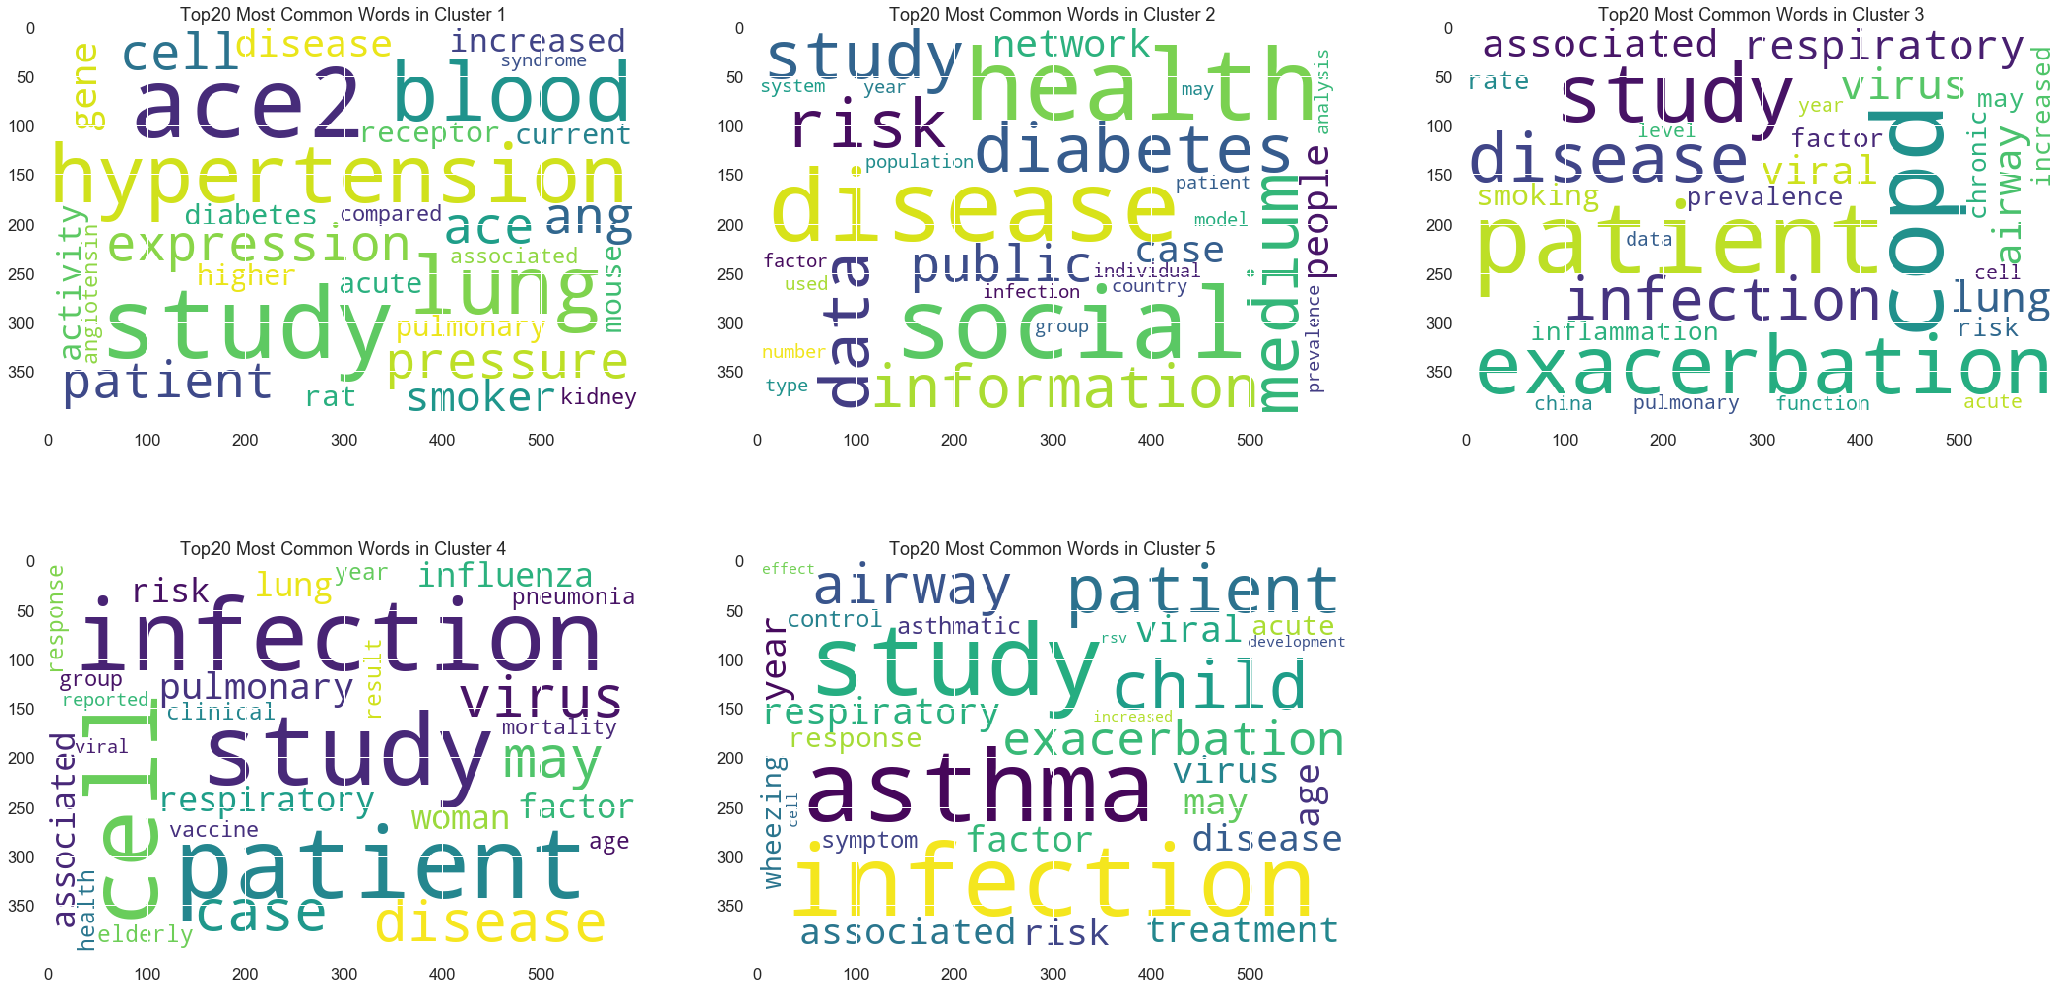

In [56]:
plt.figure(figsize=(36,18))
sns.set(font_scale=1.5)
for i in range(len(cluster_word)):
    words = cluster_word[i]
    x,y = map(list,zip(*words))
    plt.subplot(2,3,i+1)
    keywords = (' ').join(x)
    wordcloud = WordCloud(background_color="white",width=600, height=400,max_font_size=100,collocations=False).generate(keywords)
    plt.imshow(wordcloud)
    plt.title('Top20 Most Common Words in Cluster {}'.format(i+1))

- Top 20 Noun Phrases from Each Cluster

In [57]:
cluster_NP = []
for i in range(5):
    df_c = df_risk_doc[df_risk_doc.cluster==i]
    cluster_NP.append(topk_NP(df_c, 20, 'preprocessed'))

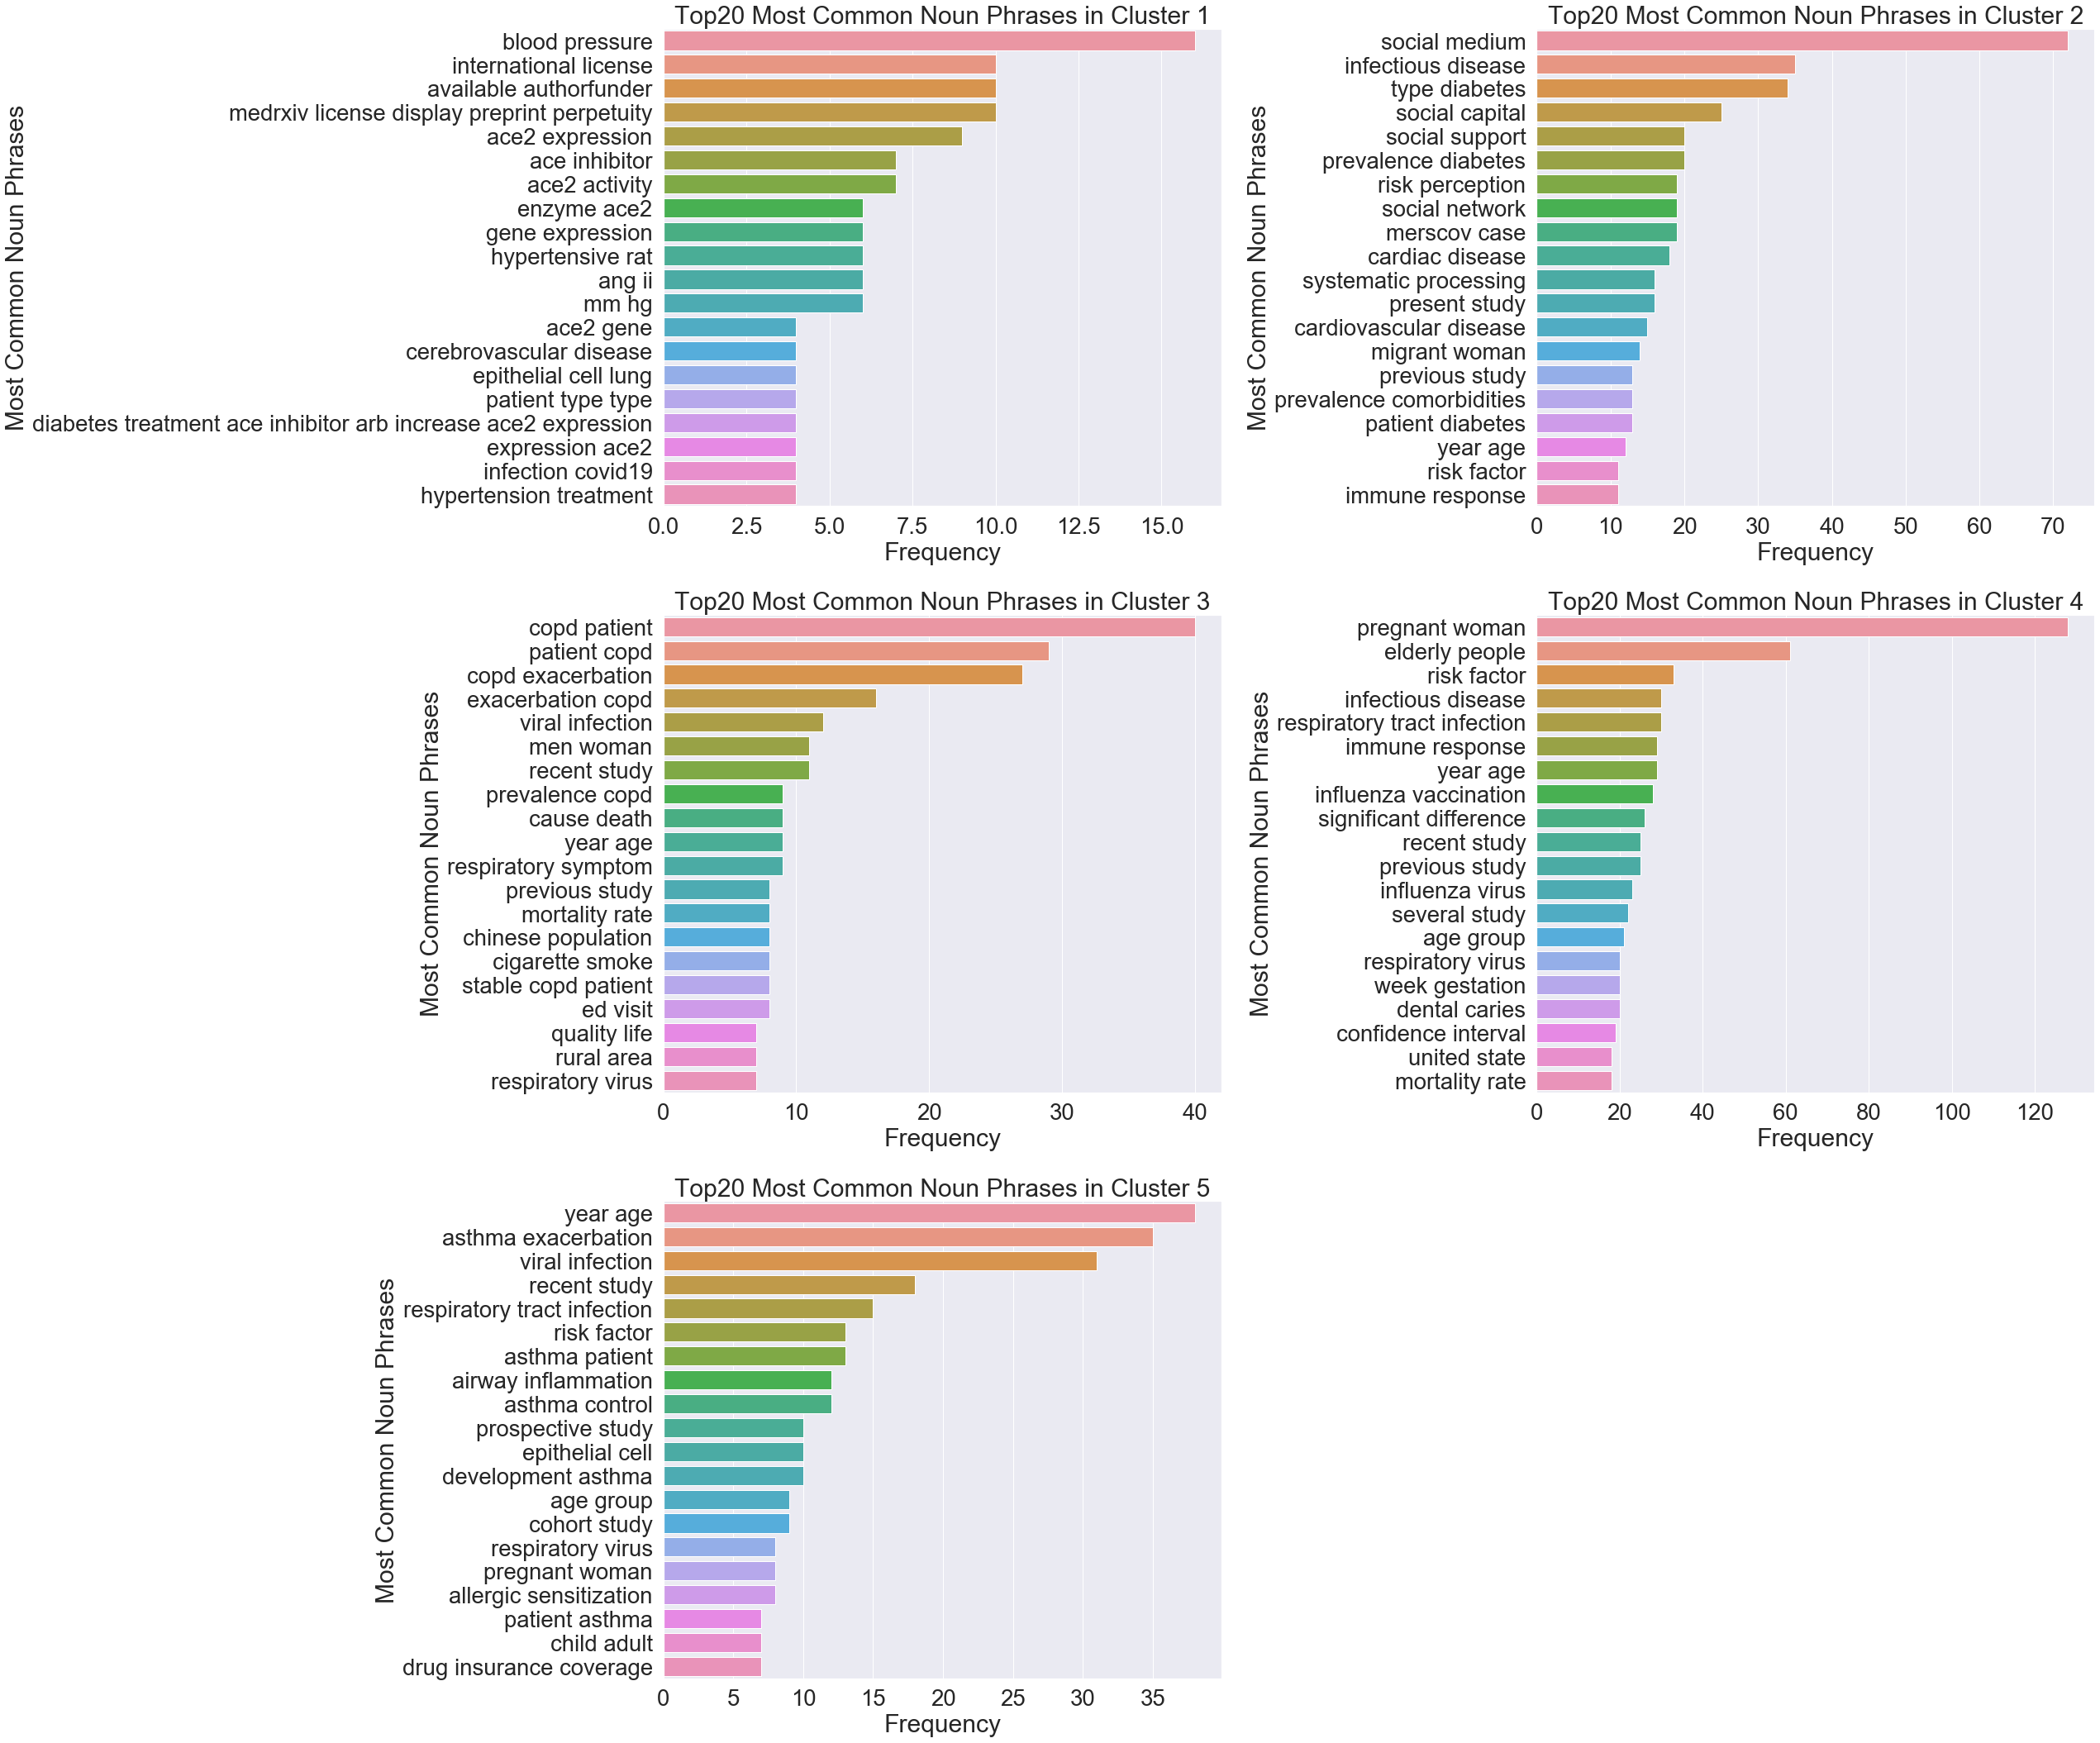

In [58]:
plt.figure(figsize=(36,30))
sns.set(font_scale=2.5)
for i in range(len(cluster_NP)):
    phrases = cluster_NP[i]
    x,y = map(list,zip(*phrases))
    plt.subplot(3,2,i+1)
    sns.barplot(x=y,y=x)
    plt.title('Top20 Most Common Noun Phrases in Cluster {}'.format(i+1))
    plt.xlabel('Frequency')
    plt.ylabel('Most Common Noun Phrases')
plt.tight_layout()

### 3.4 Documents Searching in Risk Factors Clusters

After I used K-mean to cluster the documents related to risk factors and figured out what the meanings in each cluster, I built a searching system to help doctors to find resources related to individual clusters.

For this searching system, we should firstly have the clusters and doctors have already got basic ideas in each cluster. Then doctors could specify two questions to get the relevant documents they want to read:

- In which cluster the doctors want to search in?
- How many top related documents the doctors want to read through?

The algorithm is based on the euclidean distance between individual documents and the cluster center they belong to, documents with smaller distance with cluster center will be regarded as the best representative of this cluster. Doctors could save their time in searching relevant papers, this system will automatically give them the most related papers in certain category of risk factors. For example, the doctors may want to know the risk factors related to COPD and smoking, they can simply search in cluster 2 and input how many paper they want to reference and the topk relevant papers will automatically returned to them to save their precious time.

In [59]:
def find_center_doc(cluster, array, df, df_url, center, k):
    
    df.index = list(range(len(df)))
    center_clus = cluster.cluster_centers_[center-1] #get the center of cluster
    closest = []
    for i in range(len(array)):
        a = array[i]
        closest.append([i, euclidean(center_clus, a)]) #for each documents, calculate distance with cluster center
    closest.sort(key= lambda x : x[1]) #sort distance in ascending order
    closest_index = [x[0] for x in closest[:]] #get indices of documents
    doc_info = pd.DataFrame(df.iloc[closest_index]) #get documents information
    docs = doc_info.drop_duplicates(subset='title',keep='first')[:k]
    docs.drop(['cluster'],axis=1,inplace=True)
    print('\n\n\nTop %s Documents from Cluster %s' % (k,center))
    
    display(docs)

In [60]:
center = int(input('Please Enter the Cluster Number You Would Like to Search in.(1-5)\n'))

k = int(input('PLease Enter the Number of Top Documents You Would Like to Read.(1-10)\n'))

#execute searching system
find_center_doc(cluster, model_array.toarray(), df_risk_doc, df, center, k)

Please Enter the Cluster Number You Would Like to Search in.(1-5)
2
PLease Enter the Number of Top Documents You Would Like to Read.(1-10)
5



Top 5 Documents from Cluster 2


,title,authors,abstract,preprocessed,word_vector
80,The emerging use of social media for health-re...,"Hagg, Emily; Dahinten, V. Susan; Currie, Leann...","['abstract', 'background', 'social', 'medium',...",the emerging use of social medium for health r...,"(0, 1078534)\t0.00977815799083744\n (0, 107..."
129,Prevalence of comorbidities in the Middle East...,"Badawi, Alaa; Ryoo, Seung Gwan","['summary', 'middle', 'east', 'respiratory', '...",prevalence of comorbidities in the middle east...,"(0, 1079949)\t0.013982257432355448\n (0, 10..."
87,Chapter 4 Social Media and Health Crisis Commu...,"Denecke, K.; Atique, S.","['abstract', 'reacting', 'public', 'health', '...",chapter social medium and health crisis commun...,"(0, 1074627)\t0.012028992263574654\n (0, 10..."
30,Anthropological Perspectives on the Health Tra...,"Manderson, Lenore","['abstract', 'health', 'transition', 'used', '...",anthropological perspective on the health tran...,"(0, 1079949)\t0.00751624556941813\n (0, 107..."
89,Chapter Eleven Communicating During a Public H...,"Haddow, George D.; Haddow, Kim S.","['communicating', 'public', 'health', 'crisis'...",chapter eleven communicating during public hea...,"(0, 1079764)\t0.02192678469565185\n (0, 107..."


# <center>4. Discussion<center>

**Summary of this notebook:**

The entire notebook is working on the analysis of research paper and dig insights out of them. As we see from the exploratory data analysis part, there is a very few amount of papers related to COVID-19. Therefore, this project is trying to extract experience from the past such as SARS and MERS to help a variety of people in recent days. Except for some prevalent risk factors as I retrieved from Kaggle and websites, some other risk factor that people know little about are mined and refined by information retrieval model, hierarchical and kmean clustering models. This will help people know more about the risks to get infected and let them get ready ealier to protect themselves.

**Insights**

In response to the COVID-19 pandemic, the first thing people should know is to be aware of what the risk factors are and what they can do to appease this outbreak. The retrieval system model extracts most of the real risk factors from question provided by Kaggle and web-searching so that people could get basic awareness in these keywords directly and take into actions to prevent these risks. More importantly, hierarchical clustering model categorized twelve risk factors into five groups such that every person should be able to clearly recognize their responsibilities in quelling the pandemic. In addition, one of the main focus of this project to to find potential risk factors related ones people already known about, these risk factors are extracted at the end of the K-mean model and let indivisuals to have even deeper insights on these risks.


From governments' perspectives, they should mainly focus on the 'social' and 'socioeconomic' aspects since they are responsible for making policies and stabalize the entire society. Key terms extracted from the K-mean model such as 'social medium' and 'social networking' gave us some insights in these type of risks, which government can impose regulations on citizens, such as social-distancing and self-isolation from others in the household when you feel unwell to reduce social contacting and risks to get infected. Since social and socioeconomic factors are clustere into one group in the hierarchical model, they could be regulated by goernment at the same time to save moeny and time. Furthermore, based on five categories in the model, they can also enact different policies for different groups. For example, due to the strong relationship between smoking factor and coronavirus, companies may ban smoking in working areas when work resumption takes place and governments may also impose higher taxes on cigarettes during this hard time to reduce number of smokers. Moreover, governments can encourage people to keep themselves physically healthy, monitor blood sugar level regularly and keep a healthy diet to avoid obesity, diabetes and hypertension via social medias such as TV shows and advertisements. They can also suggest people with higher risks such as pregnant women, childs, people who suffer from pulmonary disease or other comorbidities and elderly people to regularly and safely monitoring themselves, governments could also form up a team to inspect these groups of people to help them stay healthy to reduce risks.


From industry's point of view, except from imposing smoking restrictions in working places, they could change working method and allow employees to work from home. In addition, leader should take physical and mental health of their employees into consideration by controlling workloads properly during this time.


Doctors, nurses, scientists and healthcare professionals all play the most critical roles in confronting COVID-19. As the number of confirmed cases increases, doctors may feel very difficult to improve treatment efficiency in face of various clinical symptoms. To improve treatment effectively in the hospital and prepare further risks, the retrieval system and documents searching by clusters models could help them save a lot of time and then achieve their work specialization. For example, if the doctors have some problems or doubts in a specific areas such as how kidney diseases affect the chance of getting infected, then they can simply used the model to search this query and get relevant papers from the database to investigate more. 


Last but not least, nurses are the first door to knock when people feel unwell in this situation. Based on the clustering models, nurses can divide patients into five groups according to the risks they have. After that, doctors can separate into five research groups based on five categories in the model, which means they could concentrate on what they are best at. For example, obstetrician should stay in the pregnancy and neonatal group because they excel at this area; people who smoke frequently is more likely to have COPD and diagnosed with COVID-19, thus, Pulmonologist should join in the COPD and smoking group since they could provide more professional skills than other doctors. The same method also applies to scientists and healthcare professionals. They could gather clinical data from five research groups and do different scientific experiments, provide different treatment solutions to deal with different cases. To deal with emerging infected people, nurses could get trained on these risk factor to let them know more in advance about how to temporarily help the patients and increase the efficiency.

May everyone be safe and hope the pandemic will disappear soon.